# Read files

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline

In [2]:
# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 260

HCALZ_MIN = 879

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

def plot_ecal_box(ax):
    ax.add_patch(plt.Rectangle((ECALZ_MIN, -ECALW), ECALZ_MAX - ECALZ_MIN, ECALW * 2, fc=(0, 0, 0, 0), ec='red', label='ECal'))
    
def plot_hcal_box(ax):
    ax.axvline(x=HCALZ_MIN, lw=2, ls='--', color='red', label='HCal')

## Particles Class

In [3]:
labels_keys = 'electron neutron photon pion proton electron_hcal neutron_hcal photon_hcal pion_hcal proton_hcal'.split(' ')
labels_values = [
    r'Electrons $e^{\minus}$',
    r'Neutrons $n^{o}$',
    r'Photons $\gamma$',
    r'Pions $\pi^{\minus}$',
    r'Protons $p^{\plus}$',
    r'Electrons $e^{\minus}$ HCal',
    r'Neutrons $n^{o}$ HCal',
    r'Photons $\gamma$ HCal',
    r'Pions $\pi^{\minus}$ HCal',
    r'Protons $p^{\plus}$ HCal'
]

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

In [4]:
# initiate a particle class
class Particles():
    def __init__(self, hf, zero_on='PFTruthTarget_energy'):
        # a list of properties
        self.propdict = {}
        # initiate all properties
        for prop in hf.keys():
            # convert to numpy array
            self.propdict[prop] = hf[prop][()]
        self._clean_props(zero_on)
    
    # clean the data set
    def _clean_props(self, zero_on='PFTruthTarget_energy'):
        # remove on column
        if isinstance(zero_on, list):
            # invalid energy values
            zero_bool_mask = np.array(self.propdict[zero_on[0]] <= 0)
            for zero_col in zero_on[1:]:
                zero_bool_mask = np.logical_or(zero_bool_mask, np.array(self.propdict[zero_col] <= 0))
        else:
            zero_bool_mask = np.array(self.propdict[zero_on] <= 0)
            
        print(f'{np.sum(zero_bool_mask)} values removed from {zero_on}')
        
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
                print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                # set the values to zero
                self.propdict[prop][np.isnan(self.propdict[prop])] = 0
            self.propdict[prop] = self.propdict[prop][~zero_bool_mask]
                
        print('\n')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # account for mass of particle
    def acc_mass(self, mass, columns=[]):
        # subtract mass
        for column in columns:
            # clipped to zero
            # therefore, 0 -> 0, mass + energy -> energy
            self.propdict[column] = np.clip(self.propdict[column] - mass, 0, None)
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.min(self.propdict[prop]):<10.2f}{np.max(self.propdict[prop]):>8.2f}\
            {np.mean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photon']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            # set the truth energy depending on the type of particle simulation
            if (label is not None) and \
               ('HCal' in label):
                # if the particle went through both ecal and hcal
                print('HCal energy set to truth')
                energy_truth_total = self.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
            else:
                print('Target energy set to truth')
                energy_truth_total = self.get('PFTruthTarget_energy')  # the pre-target energy is set to truth

            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

# Investigate Properties

## List of Properties

In [5]:
path = 'data/test_tracks/h5_updated'
file_names = np.sort(os.listdir(path))
file_names = list(filter(lambda x: x.startswith(('pf.')), file_names))
file_names, len(file_names)

(['pf.ele_0p1_4GeV.10k.HCal.h5',
  'pf.ele_0p1_4GeV.10k.h5',
  'pf.neu_0p1_4GeV.10k.HCal.h5',
  'pf.neu_0p1_4GeV.10k.h5',
  'pf.pho_0p1_4GeV.10k.HCal.h5',
  'pf.pho_0p1_4GeV.10k.h5',
  'pf.piM_0p1_4GeV.10k.HCal.h5',
  'pf.piM_0p1_4GeV.10k.h5',
  'pf.pro_0p1_4GeV.10k.HCal.h5',
  'pf.pro_0p1_4GeV.10k.h5'],
 10)

In [6]:
# read the file

# only remove zero values for hcal (ecal before simulation)
# this is the total energy for hcal particles
electrons_hcal = Particles(h5py.File(f'{path}/pf.ele_0p1_4GeV.10k.HCal.h5', 'r'), zero_on='PFTruthHcal_energy')
photons_hcal = Particles(h5py.File(f'{path}/pf.pho_0p1_4GeV.10k.HCal.h5', 'r'), zero_on='PFTruthHcal_energy')
neutrons_hcal = Particles(h5py.File(f'{path}/pf.neu_0p1_4GeV.10k.HCal.h5', 'r'), zero_on='PFTruthHcal_energy')
pions_hcal = Particles(h5py.File(f'{path}/pf.piM_0p1_4GeV.10k.HCal.h5', 'r'), zero_on='PFTruthHcal_energy')
protons_hcal = Particles(h5py.File(f'{path}/pf.pro_0p1_4GeV.10k.HCal.h5', 'r'), zero_on='PFTruthHcal_energy')

# only remove zero values for ecal (all absorbed by ecal)
# this is the total energy for electrons and photons
target_ecal_ind = ['PFTruthTarget_energy', 'PFTruthEcal_energy']
electrons = Particles(h5py.File(f'{path}/pf.ele_0p1_4GeV.10k.h5', 'r'), zero_on=target_ecal_ind)
photons = Particles(h5py.File(f'{path}/pf.pho_0p1_4GeV.10k.h5', 'r'), zero_on=target_ecal_ind)

# remove zero values for both
target_ecal_hcal_ind = ['PFTruthTarget_energy', 'PFTruthEcal_energy', 'PFTruthHcal_energy']
neutrons = Particles(h5py.File(f'{path}/pf.neu_0p1_4GeV.10k.h5', 'r'), zero_on=target_ecal_ind)
pions = Particles(h5py.File(f'{path}/pf.piM_0p1_4GeV.10k.h5', 'r'), zero_on=target_ecal_ind)
protons = Particles(h5py.File(f'{path}/pf.pro_0p1_4GeV.10k.h5', 'r'), zero_on=target_ecal_ind)

0 values removed from PFTruthHcal_energy
9341       NaN values for PFCandidates_ecalClusterEX
9341       NaN values for PFCandidates_ecalClusterEY
9342       NaN values for PFCandidates_ecalClusterEZ
9341       NaN values for PFCandidates_ecalClusterX
9341       NaN values for PFCandidates_ecalClusterY
9341       NaN values for PFCandidates_ecalClusterZ
1          NaN values for PFCandidates_hcalClusterEX
1          NaN values for PFCandidates_hcalClusterEY
1          NaN values for PFCandidates_hcalClusterEZ
1          NaN values for PFCandidates_hcalClusterX
1          NaN values for PFCandidates_hcalClusterY
1          NaN values for PFCandidates_hcalClusterZ


0 values removed from PFTruthHcal_energy
9496       NaN values for PFCandidates_ecalClusterEX
9496       NaN values for PFCandidates_ecalClusterEY
9496       NaN values for PFCandidates_ecalClusterEZ
9496       NaN values for PFCandidates_ecalClusterX
9496       NaN values for PFCandidates_ecalClusterY
9496       NaN values f

In [7]:
_ = protons.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  9902                9835                -0.41         0.49            0.02
PFCandidates_ecalClusterDYDZ  9902                9875                -0.52         0.52            -0.00
PFCandidates_ecalClusterEDXDZ 9902                9840                0.00          0.16            0.00
PFCandidates_ecalClusterEDYDZ 9902                9872                0.00          0.13            0.00
PFCandidates_ecalClusterEX    9902                9761                0.00        142.67            29.42
PFCandidates_ecalClusterEY    9902                9745                0.00        117.29            29.25
PFCandidates_ecalClusterEZ    9902                7695                0.00        216.28            98.88
PFCandidates_ecalClusterX     9902                9734                -178.75     186.04            8.99
PFCandidates_ecalClusterY     9902                9

## Correct for mass

In [8]:
# define the particle mass [MeV]
electron_mass = 0.511
neutron_mass = 939.56
photon_mass = 0
pion_mass = 139.57
proton_mass = 938.27

# subtract rest mass from the total energies, leaving kinetic
# do not include measured energies
hcal_cols = 'PFTruthHcal_energy'.split(' ')
full_cols = 'PFTruthTarget_energy PFTruthEcal_energy PFTruthHcal_energy PFCandidates_truthEnergy'.split(' ')

# subtract the mass
electrons_hcal.acc_mass(electron_mass, columns=hcal_cols)
electrons.acc_mass(electron_mass, columns=full_cols)
neutrons_hcal.acc_mass(neutron_mass, columns=hcal_cols)
neutrons.acc_mass(neutron_mass, columns=full_cols)
photons_hcal.acc_mass(photon_mass, columns=hcal_cols)
photons.acc_mass(photon_mass, columns=full_cols)
pions_hcal.acc_mass(pion_mass, columns=hcal_cols)
pions.acc_mass(pion_mass, columns=full_cols)
protons_hcal.acc_mass(proton_mass, columns=hcal_cols)
protons.acc_mass(proton_mass, columns=full_cols)

In [9]:
# column names
_ = neutrons.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  9881                7312                -0.52         0.57            0.00
PFCandidates_ecalClusterDYDZ  9881                7314                -0.54         0.50            0.00
PFCandidates_ecalClusterEDXDZ 9881                7313                0.00          0.19            0.00
PFCandidates_ecalClusterEDYDZ 9881                7315                0.00          0.15            0.00
PFCandidates_ecalClusterEX    9881                7514                0.00        161.13            27.74
PFCandidates_ecalClusterEY    9881                7433                0.00        161.46            27.69
PFCandidates_ecalClusterEZ    9881                7006                0.00        218.70            45.73
PFCandidates_ecalClusterX     9881                7583                -253.37     257.58            1.29
PFCandidates_ecalClusterY     9881                71

## Summary

In [10]:
display_df = {
    'Names' : ['PFCandidates_ecalEnergy', 'PFCandidates_hcalEnergy', 'PFCandidates_energy', 'PFTruthEcal_energy', 'PFTruthHcal_energy', 'PFTruthTarget_energy'],
    'Data' : ['Measured ECal energy', 'Measured HCal energy', 'Measured sum energy', 'Energy in front of ECal', 'Energy in front of HCal', 'Energy in front of recoil tracker']
}

display_df = pd.DataFrame(display_df)
display(display_df)

Names                               Data
0  PFCandidates_ecalEnergy               Measured ECal energy
1  PFCandidates_hcalEnergy               Measured HCal energy
2      PFCandidates_energy                Measured sum energy
3       PFTruthEcal_energy            Energy in front of ECal
4       PFTruthHcal_energy            Energy in front of HCal
5     PFTruthTarget_energy  Energy in front of recoil tracker

In [11]:
# verify that total energy is hcal + ecal
print(electrons.get('PFCandidates_energy') - electrons.get('PFCandidates_hcalEnergy'))
print(electrons.get('PFCandidates_ecalEnergy'))

[2578.7964 2804.276  1355.7954 ... 2898.0115 1224.5817 3891.8264]
[2578.7964 2804.276  1355.7954 ... 2898.0115 1224.5817 3891.8264]


# First-Order Energy Corrections

Axes limits [13.633378028869629, 3999.133056640625] and [0.09868235141038895, 5876.83544921875]


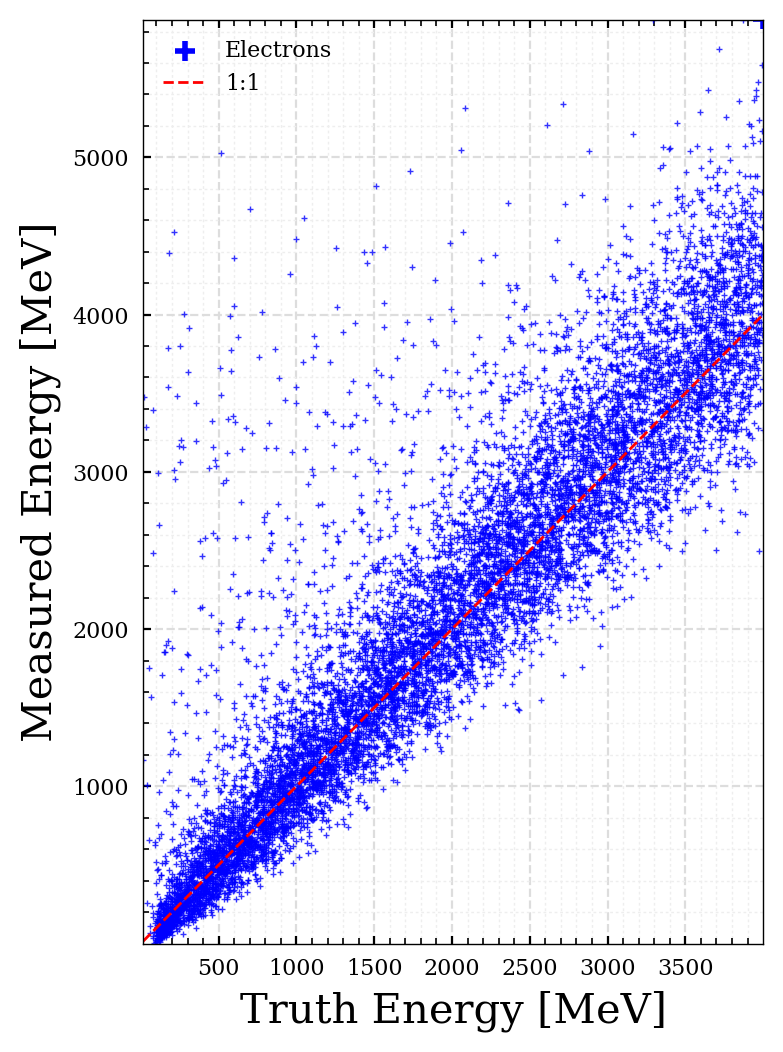

In [12]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=200)
plotting.scatter(fig, ax,
                 electrons.get('PFTruthTarget_energy'), electrons.get('PFCandidates_energy'),
                 xlim=None, ylim=None,
                 label='Electrons',
                 draw_line=True, line_prop = [None, None, 1, '--', 'red', '1:1'],
                 xlabel = 'Truth Energy [MeV]', ylabel = 'Measured Energy [MeV]')

Axes limits [0, 4000.0] and [4.995575428009033, 5753.07568359375]


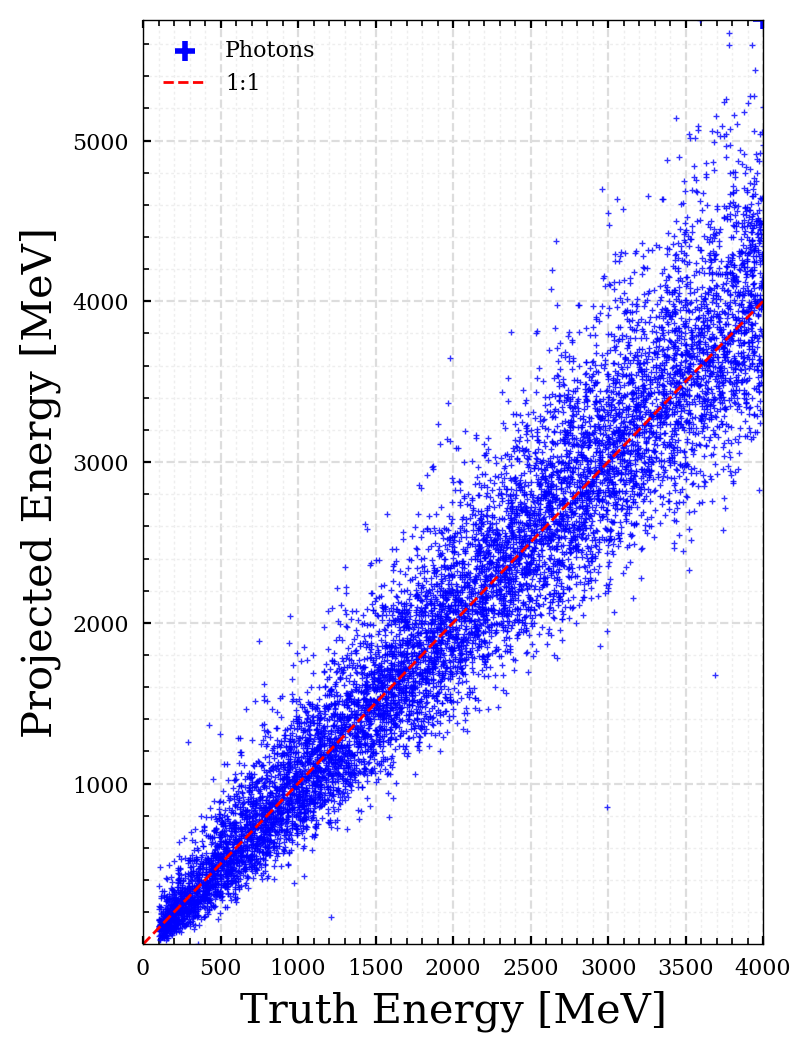

In [13]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=200)
plotting.scatter(fig, ax,
                 photons.get('PFTruthTarget_energy'), photons.get('PFCandidates_energy'),
                 xlim=[0, 4e3], ylim=None,
                 label='Photons',
                 draw_line=True, line_prop = [None, None, 1, '--', 'red', '1:1'],
                 xlabel = 'Truth Energy [MeV]', ylabel = 'Projected Energy [MeV]')

Axes limits [13.633378028869629, 3999.133056640625] and (0, 2)


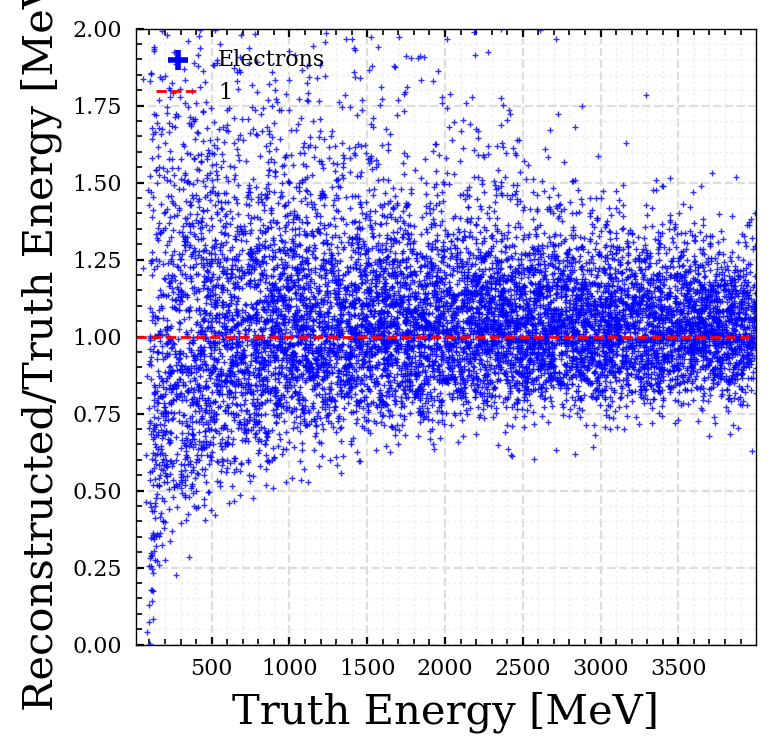

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
plotting.scatter(fig, ax,
                 electrons.get('PFTruthTarget_energy'), electrons.get('PFCandidates_energy')/(electrons.get('PFTruthTarget_energy')+0.0001),
                 xlim=None, ylim=(0, 2),
                 label='Electrons',
                 draw_line=True, line_prop = [None, np.ones_like, 1, '--', 'red', '1'],
                 xlabel = 'Truth Energy [MeV]', ylabel = 'Reconstructed/Truth Energy [MeV]')

## Proportions of energy deposition

In [15]:
np.mean(electrons.get('PFCandidates_ecalEnergy')), np.mean(electrons.get('PFCandidates_hcalEnergy'))

(2131.817, 0.46210766)

In [16]:
np.mean(photons.get('PFCandidates_ecalEnergy')), np.mean(photons.get('PFCandidates_hcalEnergy'))

(2088.6367, 0.47377953)

In [17]:
np.mean(neutrons.get('PFCandidates_ecalEnergy')), np.mean(neutrons.get('PFCandidates_hcalEnergy'))

(1110.0796, 74.771706)

In [18]:
np.mean(pions.get('PFCandidates_ecalEnergy')), np.mean(pions.get('PFCandidates_hcalEnergy'))

(621.1609, 200.84013)

In [19]:
np.mean(protons.get('PFCandidates_ecalEnergy')), np.mean(protons.get('PFCandidates_hcalEnergy'))

(1363.4342, 61.40925)

## Apply ECal cut

Cut out particles that don't hit ECal

In [20]:
out_mask = np.logical_or(np.logical_or(electrons.get('PFCandidates_posEcalX') > 260,
                                       electrons.get('PFCandidates_posEcalX') < -260),
                         np.logical_or(electrons.get('PFCandidates_posEcalY') > 260,
                                       electrons.get('PFCandidates_posEcalY') < -260))
print(np.sum(out_mask))

out_mask = np.logical_or(np.logical_or(electrons.get('PFCandidates_truthEcalX') > 260,
                                       electrons.get('PFCandidates_truthEcalX') < -260),
                         np.logical_or(electrons.get('PFCandidates_truthEcalY') > 260,
                                       electrons.get('PFCandidates_truthEcalY') < -260))
print(np.sum(out_mask))

9
9


In [21]:
out_mask = np.logical_or(np.logical_or(photons.get('PFCandidates_posEcalX') > 260,
                                       photons.get('PFCandidates_posEcalX') < -260),
                         np.logical_or(photons.get('PFCandidates_posEcalY') > 260,
                                       photons.get('PFCandidates_posEcalY') < -260))
print(np.sum(out_mask))

out_mask = np.logical_or(np.logical_or(photons.get('PFCandidates_truthEcalX') > 260,
                                       photons.get('PFCandidates_truthEcalX') < -260),
                         np.logical_or(photons.get('PFCandidates_truthEcalY') > 260,
                                       photons.get('PFCandidates_truthEcalY') < -260))
print(np.sum(out_mask))

0
0


## Apply the bin coefficient

The cuts will be based on the proportions between `PFTruthTarget_energy` and `PFCandidates_energy` (which is the sum of detector `PFCandidates_ecalEnergy` + `PFCandidates_hcalEnergy`). This constant is then applied based on each bin of `PFCandidates_ecalEnergy` to produce `energy_o1corr_ecal`

In [22]:
def o1corr_ecal(particles, bin_size = 500, label = labels_dict['photon']):
    """
    Do the correction
    """
    # original plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    energy_bins, energy_bins_avg, o1corr_bins, (XY_32, XY_68), (XY_05, XY_95) = plotting.percentile(
        particles.get('PFCandidates_energy'),
        particles.get('PFTruthTarget_energy')/\
                      (particles.get('PFCandidates_energy')),
        binwidth=bin_size, style=style, floor=True, label='Correction Coeff', textpos=[3500, 1.5])
    plt.xlabel('Measured Energy [MeV]')
    plt.ylabel('Truth / Measured Energy Bin-Wise Correction', fontsize=10)
    plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    
    # print out the energy corrections
    print(f'Average energy correction is {np.mean(o1corr_bins)}')
    
    # clip the correction to < 1 for reco energy > 4 GeV (truth energy always smaller than measured)
    o1corr_bins = np.where(energy_bins[1:] > 4e3,  # 4000 MeV
                           np.clip(o1corr_bins,
                                   a_min=0., a_max=1.),  # clip to max of 1
                           o1corr_bins)
    
    # first order corrected energy
    energy_o1corr = pd.cut(particles.get('PFCandidates_ecalEnergy'), bins=energy_bins,
                           include_lowest=True, labels=o1corr_bins).to_numpy()
    energy_o1corr_ecal = particles.get('PFCandidates_ecalEnergy') * energy_o1corr\
                                                     + particles.get('PFCandidates_hcalEnergy')
    
    
    """
    Plot the corrected energies
    """
    
    # O(1) correction plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    _ = plotting.percentile(
        particles.get('PFTruthTarget_energy'),
        particles.get('PFCandidates_energy') / (particles.get('PFTruthTarget_energy') + 1e-4),
        binwidth=bin_size, style=style, floor=True, color='red', label='Measured', textpos=[3500, 1.5])
    _ = plotting.percentile(
        particles.get('PFTruthTarget_energy'),
        energy_o1corr_ecal / (particles.get('PFTruthTarget_energy') + 1e-4),
        binwidth=bin_size, style=style, floor=True, color='blue', label='$\mathcal{O}(1)$ Reconstructed')
    plt.xlabel('Truth Energy [MeV]')
    plt.ylabel('Reconstructed / Truth ECal Energy', fontsize=10)
    plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    
    # O(1) correction plot, naively plotting against measured values
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    _ = plotting.percentile(
        particles.get('PFCandidates_energy'),
        particles.get('PFCandidates_energy') / (particles.get('PFTruthTarget_energy') + 1e-4),
        binwidth=bin_size, style=style, floor=True, color='red', label='Measured', textpos=[3500, 1.5])
    _ = plotting.percentile(
        particles.get('PFCandidates_energy'),
        energy_o1corr_ecal / (particles.get('PFTruthTarget_energy') + 1e-4),
        binwidth=bin_size, style=style, floor=True, color='blue', label='$\mathcal{O}(1)$ Reconstructed')
    plt.xlabel('Measured Energy [MeV]')
    plt.ylabel('Reconstructed / Truth ECal Energy', fontsize=10)
    plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=10, weight='bold')
    
    # return the bin edges (in MeV of measured energy) and correction coefficients
    return energy_bins, o1corr_bins

### Electrons

(9965,) (9965,)
(9965,) (9965,)
(12,) (12,) (12,)
Average energy correction is 0.9138830974698067
(9965,) (9965,)
(9965,) (9965,)
(8,) (8,) (8,)
(9965,) (9965,)
(9965,) (9965,)
(8,) (8,) (8,)
(9965,) (9965,)
(9965,) (9965,)
(12,) (12,) (12,)
(9965,) (9965,)
(9965,) (9965,)
(12,) (12,) (12,)


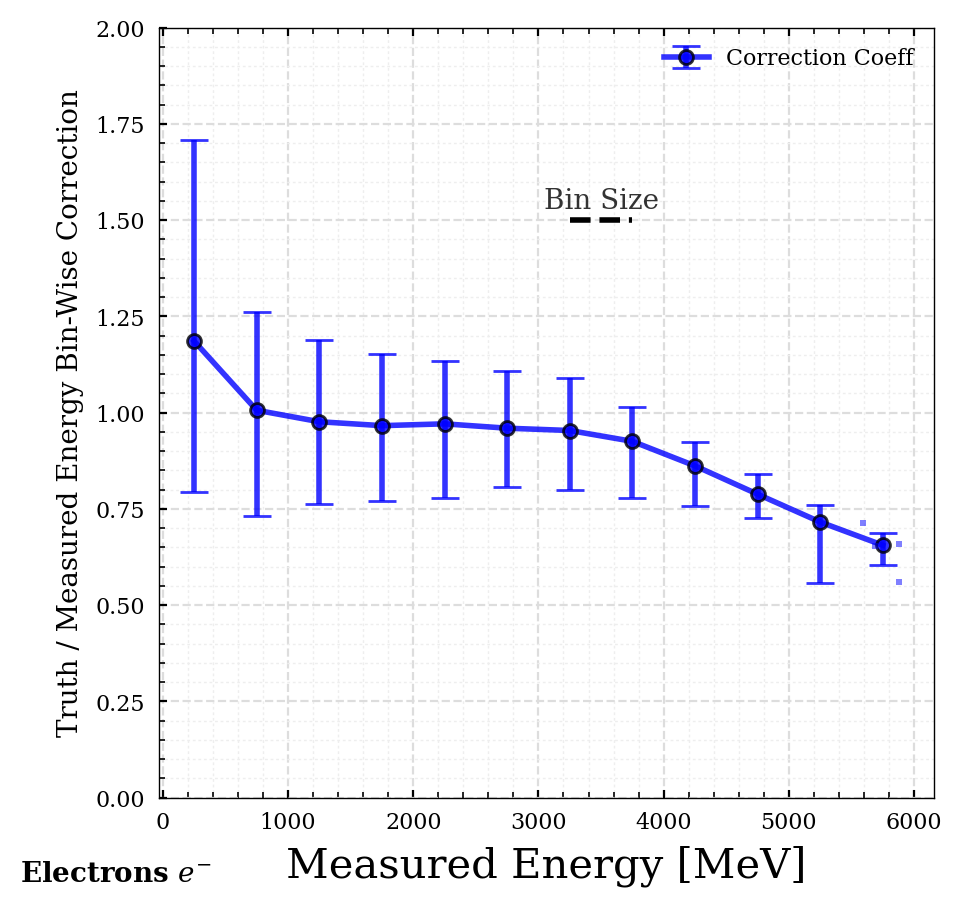

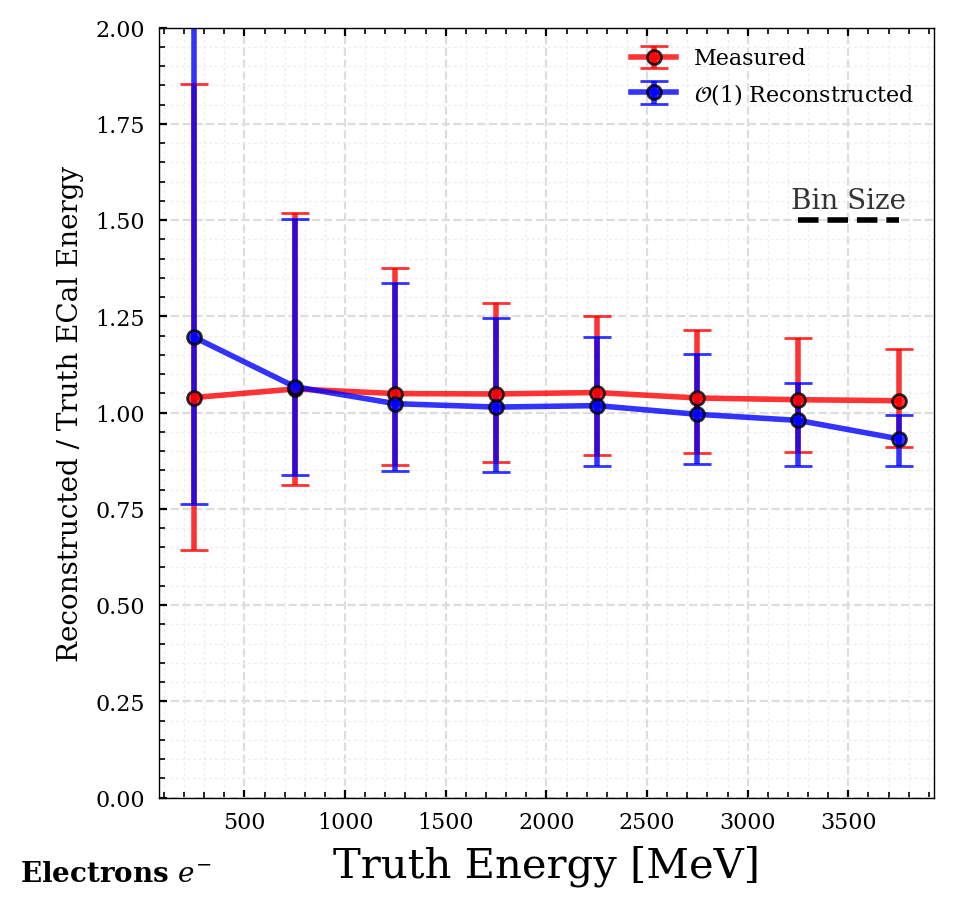

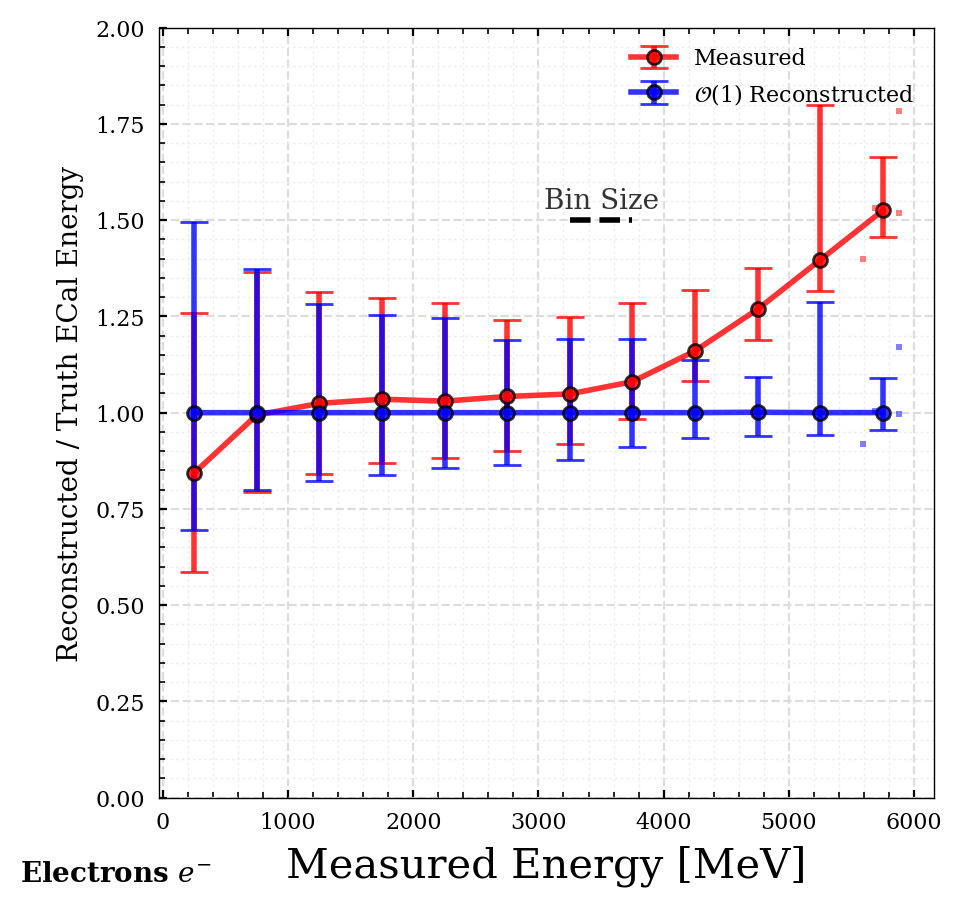

In [23]:
ele_energy_bins_ecal, ele_o1corr_ecal = o1corr_ecal(electrons, bin_size=500, label=labels_dict['electron'])

In [24]:
ele_energy_bins_ecal, len(ele_energy_bins_ecal)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.]),
 13)

The bins are correctly separated and floored, and have one more element (edges) than the coefficients

In [25]:
ele_o1corr_ecal, len(ele_o1corr_ecal)

(array([1.18598557, 1.00625324, 0.97645277, 0.96624851, 0.97098845,
        0.95967686, 0.95366329, 0.92554763, 0.86182195, 0.7882978 ,
        0.71596402, 0.65569708]),
 12)

### Photons

Doing the same, but for photons

(9378,) (9378,)
(9378,) (9378,)
(12,) (12,) (12,)
Average energy correction is 0.9407399495442709
(9378,) (9378,)
(9378,) (9378,)
(8,) (8,) (8,)
(9378,) (9378,)
(9378,) (9378,)
(8,) (8,) (8,)
(9378,) (9378,)
(9378,) (9378,)
(12,) (12,) (12,)
(9378,) (9378,)
(9378,) (9378,)
(12,) (12,) (12,)


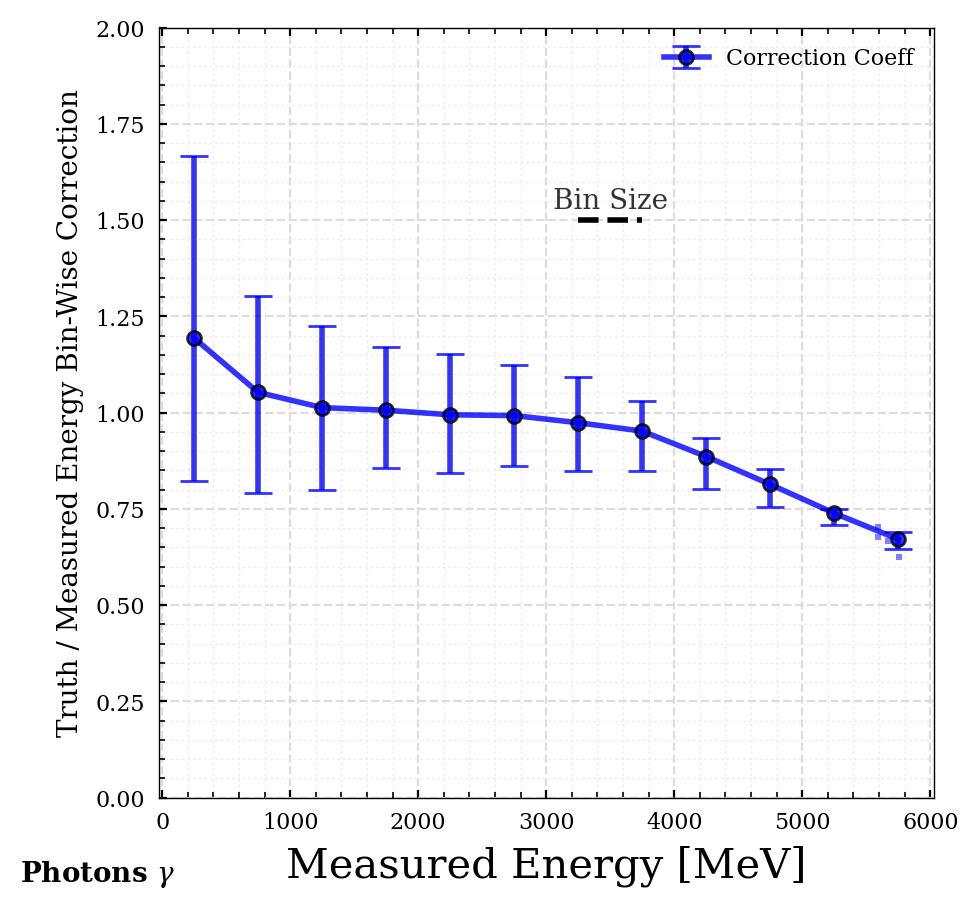

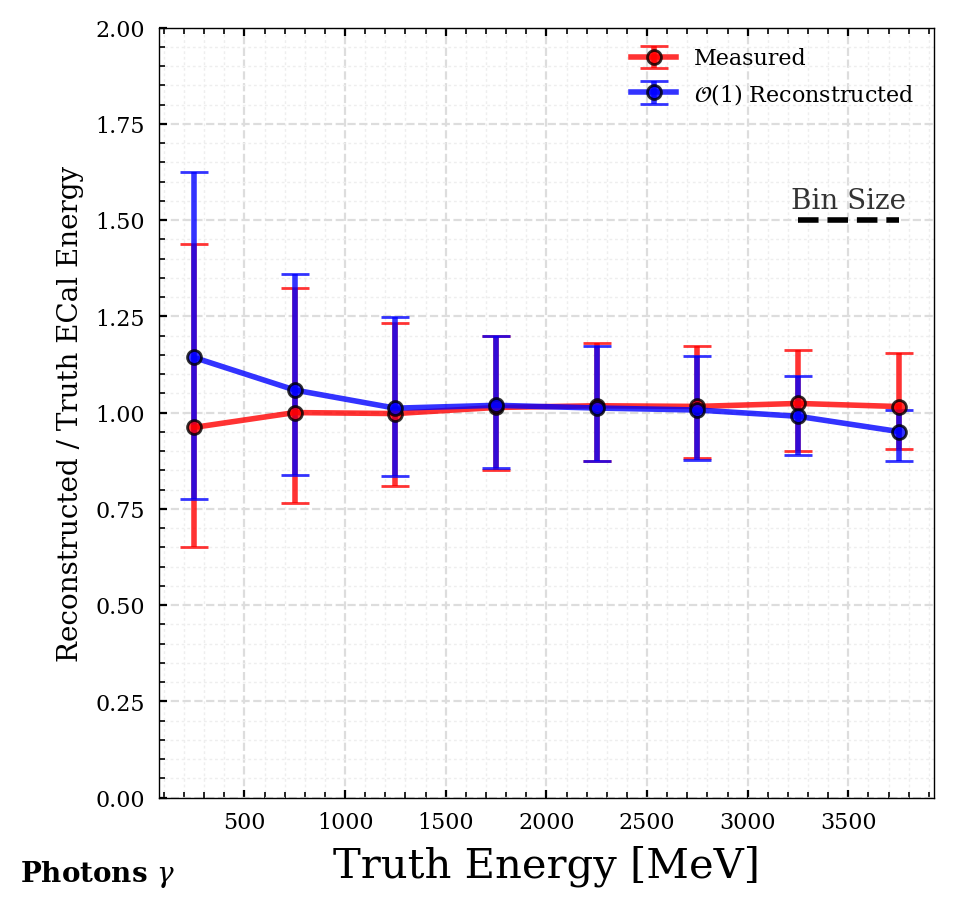

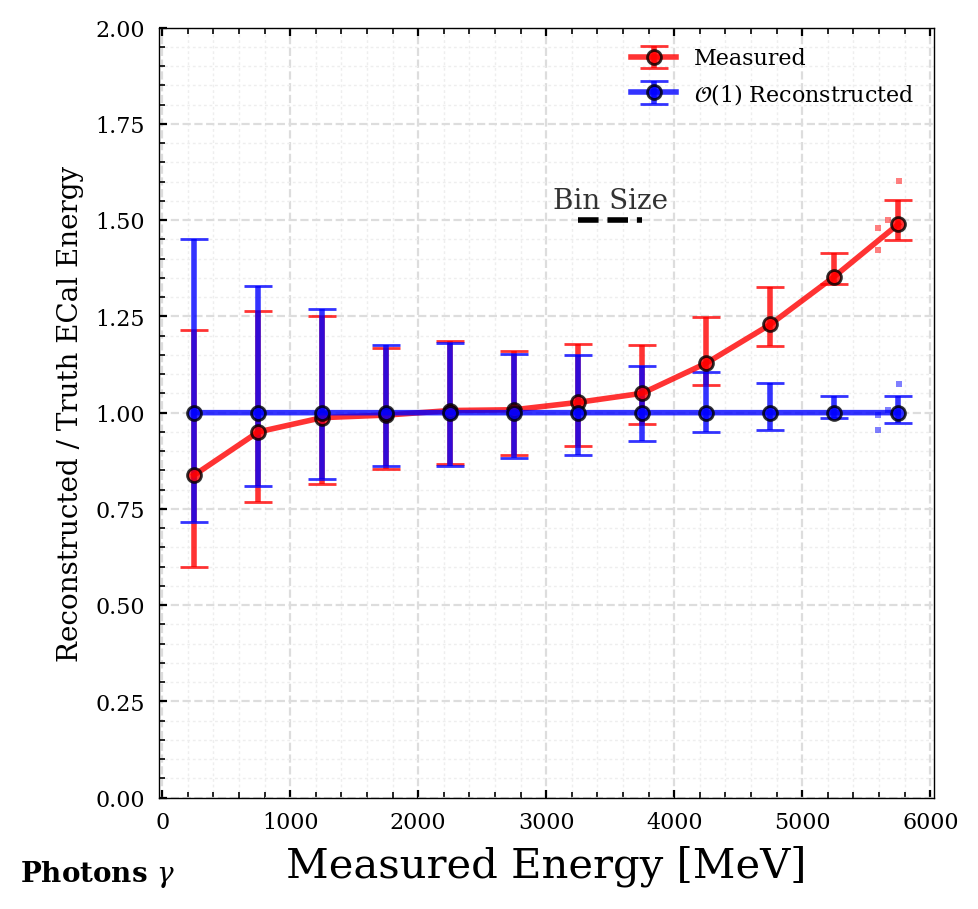

In [26]:
pho_energy_bins_ecal, pho_o1corr_ecal = o1corr_ecal(photons, bin_size=500, label=labels_dict['photon'])

In [27]:
pho_energy_bins_ecal, len(pho_energy_bins_ecal)

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.]),
 13)

In [28]:
pho_o1corr_ecal, len(pho_o1corr_ecal)

(array([1.19377148, 1.05279595, 1.01311707, 1.00635087, 0.99447447,
        0.99247414, 0.97390121, 0.95206821, 0.88605094, 0.81365258,
        0.73887473, 0.67134774]),
 12)

## HCal Corrections

In [29]:
def o1corr_hcal(particles, bin_size = 500, label = labels_dict['photon'], ecal_params = [[0, 6e3], [1]]):
    """
    ecal_corr : [part_energy_bins, part_o1corr_ecal], length [nbins+1, nbins]
    Do the correction
    """
    # original plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    energy_bins, energy_bins_avg, o1corr_bins, (XY_32, XY_68), (XY_05, XY_95) = plotting.percentile(
        particles.get('PFCandidates_hcalEnergy'),  # observed energy
        particles.get('PFTruthHcal_energy')/particles.get('PFCandidates_hcalEnergy'),
        binwidth=bin_size, style=style, floor=True, label='Correction Coeff', textpos=[400, 12])
    plt.xlabel('Measured HCal Energy [MeV]')
    plt.ylabel('Truth / Measured HCal Energy Bin-Wise Correction', fontsize=10)
    #plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')
    
    # print out the energy corrections
    print(f'Average energy correction is {np.mean(o1corr_bins)}:')
    
    # clip the correction to < 1 for reco energy > 4 GeV (truth energy always smaller than measured)
    o1corr_bins = np.where(energy_bins[1:] > 4e3,  # 4000 MeV
                           np.clip(o1corr_bins,
                                   a_min=0., a_max=1.),# - 1e-4 * np.random.randn(o1corr_bins.shape),  # clip to max of 1
                           o1corr_bins)
    
    print(energy_bins)
    print(o1corr_bins)
    
    # first order corrected HCAL energy
    o1corr_hcal = pd.cut(particles.get('PFCandidates_hcalEnergy'), bins=energy_bins,
                           include_lowest=True, labels=o1corr_bins).to_numpy()
    energy_o1corr_hcal = particles.get('PFCandidates_hcalEnergy') * o1corr_hcal
    
    """
    Plot the corrected energies
    """
    
    # O(1) correction plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    _ = plotting.percentile(  # measured hcal energy
        particles.get('PFTruthHcal_energy'),
        particles.get('PFCandidates_hcalEnergy') / particles.get('PFTruthHcal_energy'),
        binwidth=bin_size*10, style=style, floor=True, color='red', label='Measured', textpos=[3500, 1.2])
    _ = plotting.percentile(  # reconstructed hcal energy
        particles.get('PFTruthHcal_energy'),
        energy_o1corr_hcal / particles.get('PFTruthHcal_energy'),
        binwidth=bin_size*10, style=style, floor=True, color='blue', label='$\mathcal{O}(1)$ Reconstructed')
    plt.xlabel('Truth HCal Energy [MeV]')
    plt.ylabel('Reconstructed / Truth HCal Energy', fontsize=10)
    #plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')
    
    # O(1) correction plot, with both energies
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    _ = plotting.percentile(
        particles.get('PFCandidates_hcalEnergy'),
        particles.get('PFCandidates_hcalEnergy')/particles.get('PFTruthHcal_energy'),
        binwidth=bin_size, style=style, floor=True, color='red', label='Measured', textpos=[600, 1.2])
    _ = plotting.percentile(
        particles.get('PFCandidates_energy'),  # for every measured energy, the reconstructed is on point
        energy_o1corr_hcal / particles.get('PFTruthHcal_energy'),
        binwidth=bin_size, style=style, floor=True, color='blue', label='$\mathcal{O}(1)$ Reconstructed')
    plt.xlabel('Measured HCal Energy [MeV]')
    plt.ylabel('Reconstructed / Truth HCal Energy', fontsize=10)
    #plt.ylim(0, 2)
    plt.legend(loc='upper right')
    plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')
    
    # return the bin edges (in MeV of measured energy) and correction coefficients
    return energy_bins, o1corr_bins

### Electrons

Axes limits [0, 800] and [0, 100]


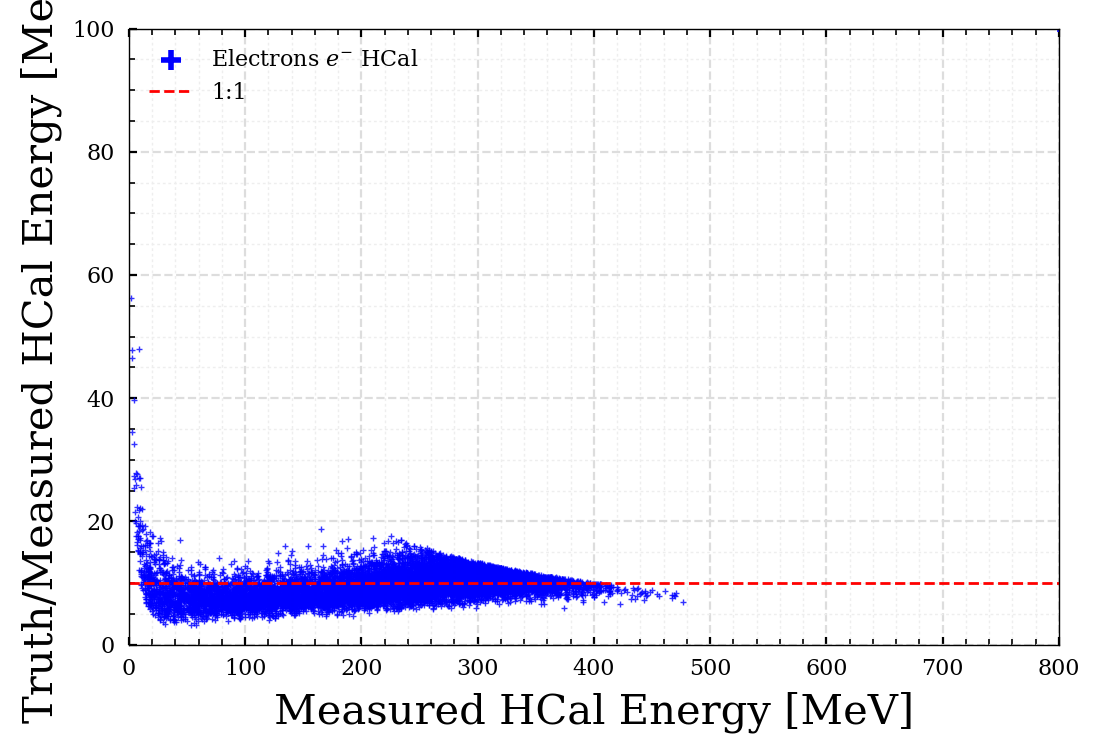

In [30]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plotting.scatter(fig, ax,
                 electrons_hcal.get('PFCandidates_hcalEnergy'),
                 electrons_hcal.get('PFTruthHcal_energy')/electrons_hcal.get('PFCandidates_hcalEnergy'),
                 xlim=[0, 800], ylim=[0, 100],
                 label=labels_dict['electron']+' HCal',
                 draw_line=True, line_prop = [None, lambda x: [10]*len(x), 1, '--', 'red', '1:1'],
                 xlabel = 'Measured HCal Energy [MeV]', ylabel = 'Truth/Measured HCal Energy [MeV]')

(9999,) (9999,)
(9999,) (9999,)
(10,) (10,) (10,)
Average energy correction is 8.956021356582642:
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500.]
[ 8.72792101  7.47605658  7.8331418   8.58382893  9.46359539 10.44721127
 10.46484852  9.68849564  8.86627007  8.00884438]
(10000,) (10000,)
(10000,) (10000,)
(8,) (8,) (8,)
(10000,) (10000,)
(10000,) (10000,)
(8,) (8,) (8,)
(10000,) (10000,)
(10000,) (10000,)
(10,) (10,) (10,)
(10000,) (10000,)
(9999,) (9999,)
(11,) (11,) (11,)


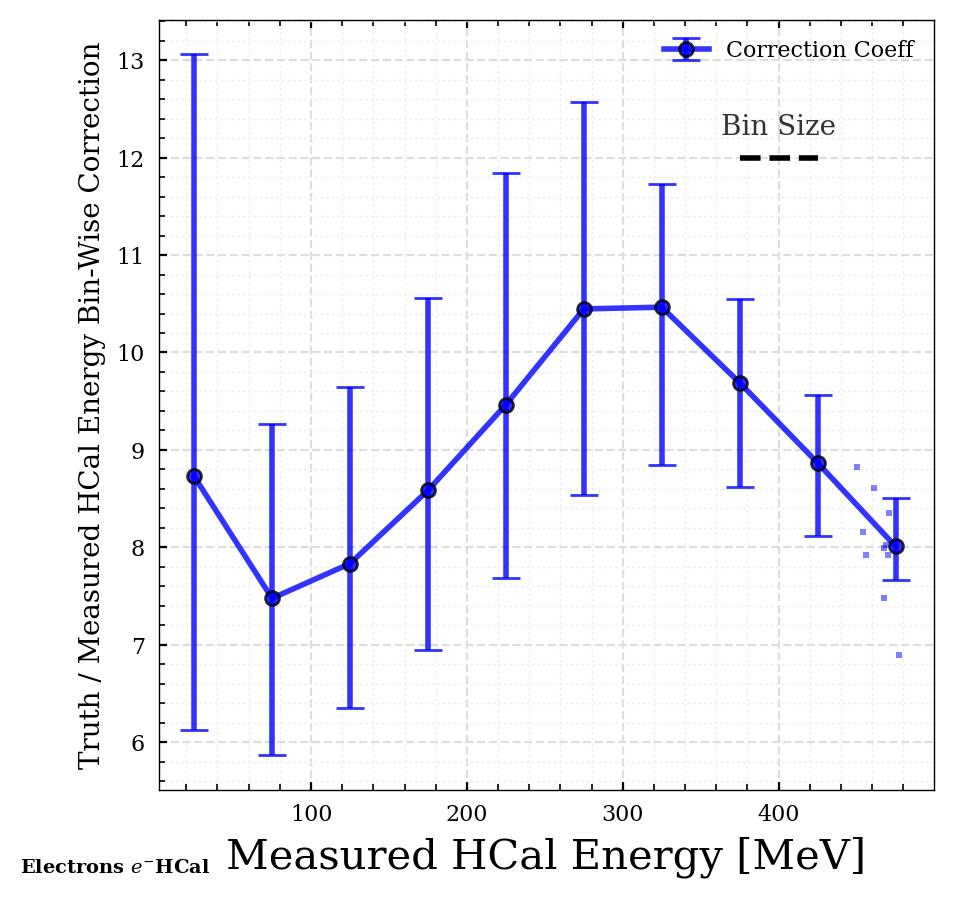

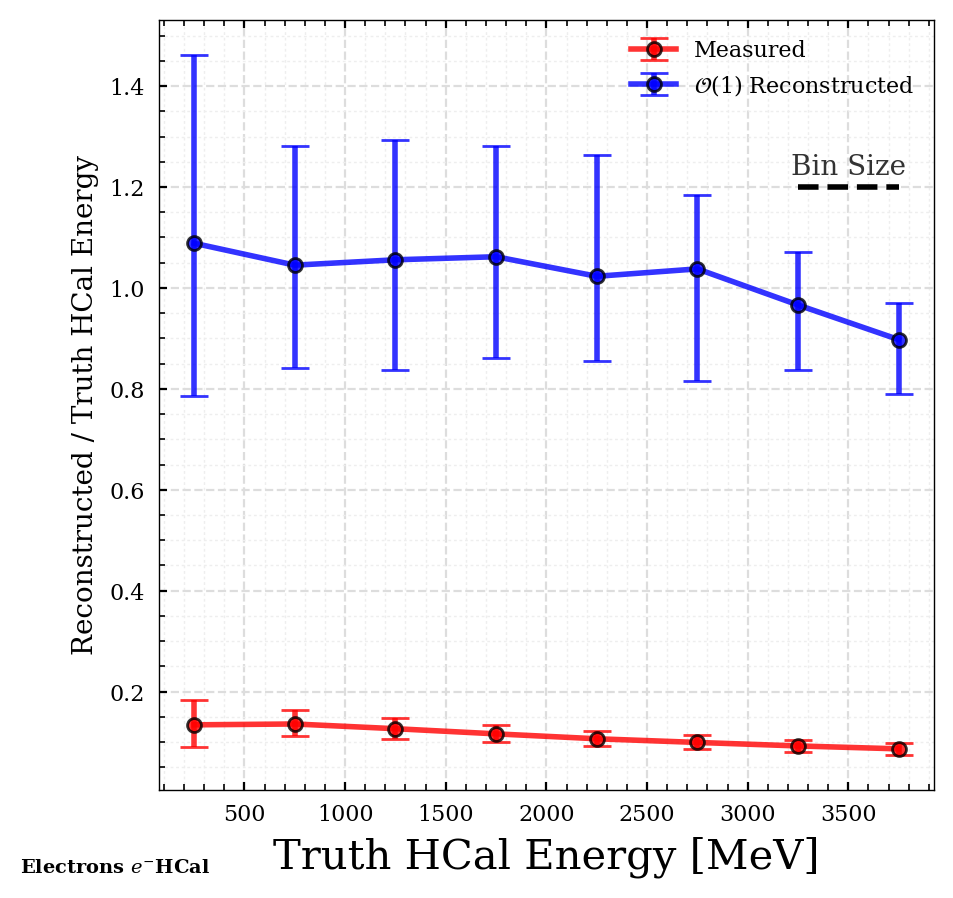

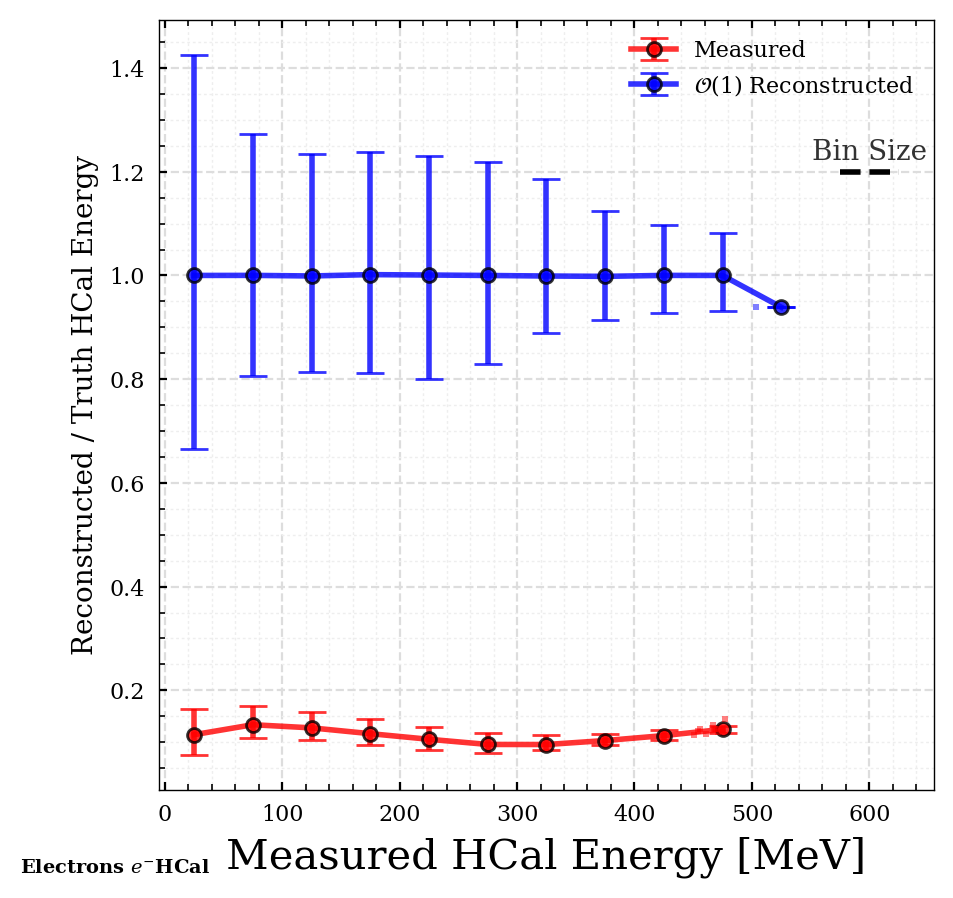

In [31]:
ele_energy_bins_hcal, ele_o1corr_hcal = o1corr_hcal(electrons_hcal, bin_size=50,
                                               label=labels_dict['electron']+'HCal',
                                               ecal_params=[ele_energy_bins_ecal, ele_o1corr_ecal])

In [32]:
ele_energy_bins_hcal, len(ele_energy_bins_hcal)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]), 11)

In [33]:
ele_o1corr_hcal, len(ele_o1corr_hcal)

(array([ 8.72792101,  7.47605658,  7.8331418 ,  8.58382893,  9.46359539,
        10.44721127, 10.46484852,  9.68849564,  8.86627007,  8.00884438]),
 10)

### Photons

Axes limits [0, 800] and [0, 100]


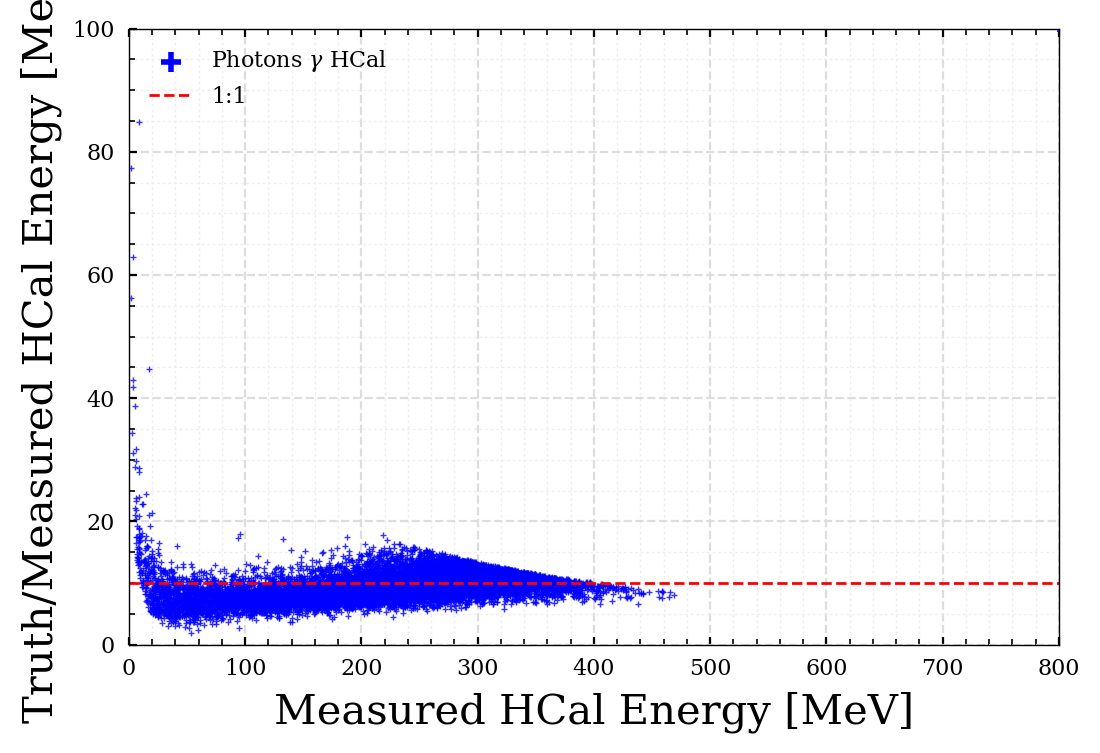

In [34]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plotting.scatter(fig, ax,
                 photons_hcal.get('PFCandidates_hcalEnergy'),
                 photons_hcal.get('PFTruthHcal_energy')/photons_hcal.get('PFCandidates_hcalEnergy'),
                 xlim=[0, 800], ylim=[0, 100],
                 label=labels_dict['photon']+' HCal',
                 draw_line=True, line_prop = [None, lambda x: [10]*len(x), 1, '--', 'red', '1:1'],
                 xlabel = 'Measured HCal Energy [MeV]', ylabel = 'Truth/Measured HCal Energy [MeV]')

(10000,) (10000,)
(10000,) (10000,)
(10,) (10,) (10,)
Average energy correction is 8.905591154098511:
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500.]
[ 8.12814999  7.27960443  7.68240547  8.48420715  9.47431278 10.44567299
 10.46855545  9.72650146  8.87418842  8.49231339]
(10000,) (10000,)
(10000,) (10000,)
(8,) (8,) (8,)
(10000,) (10000,)
(10000,) (10000,)
(8,) (8,) (8,)
(10000,) (10000,)
(10000,) (10000,)
(10,) (10,) (10,)
(10000,) (10000,)
(9999,) (9999,)
(10,) (10,) (10,)


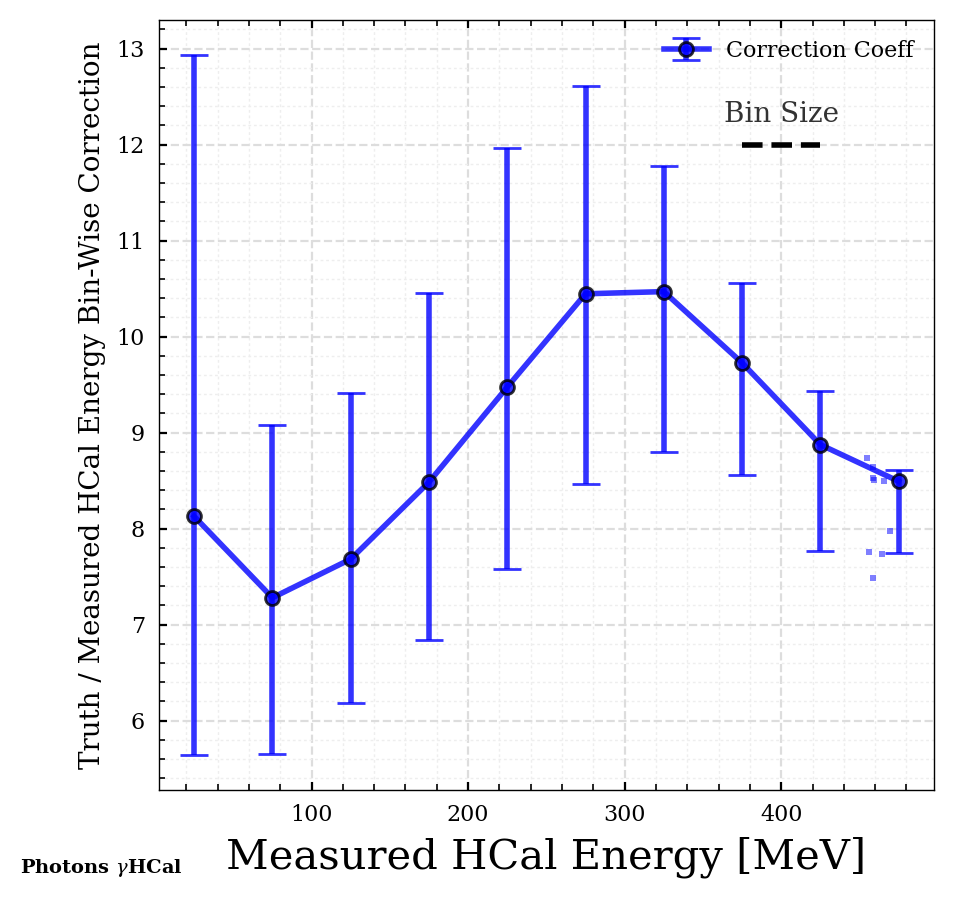

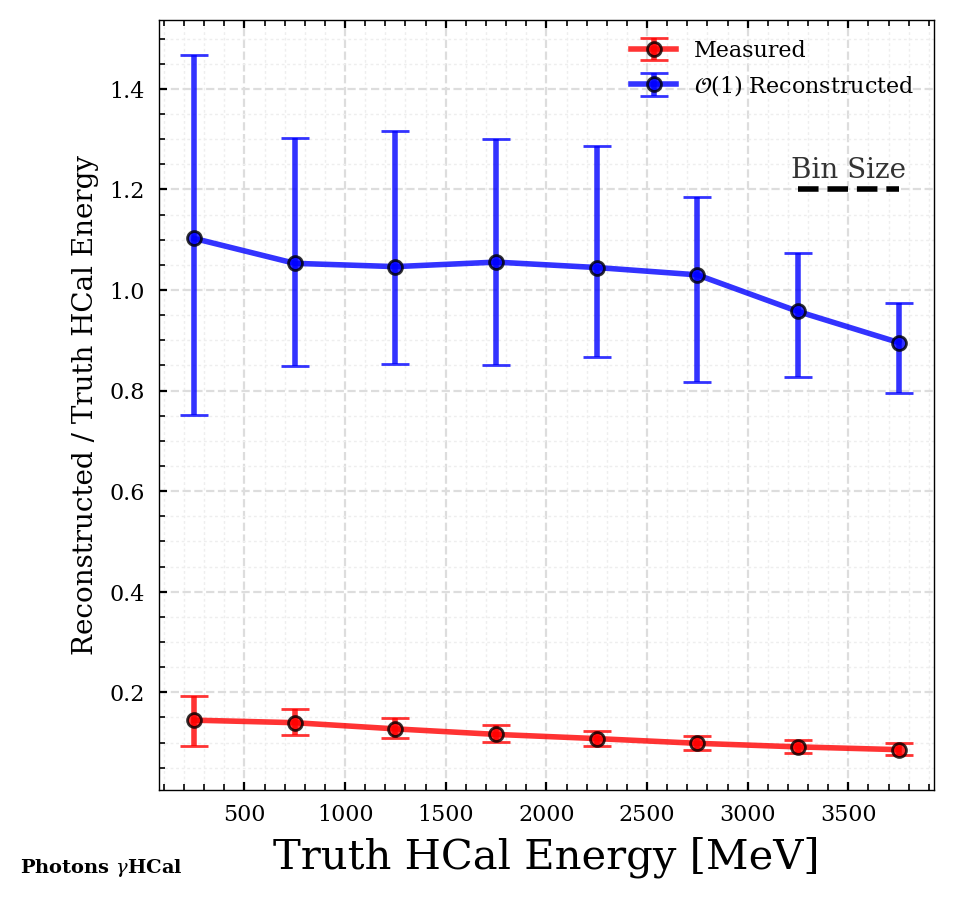

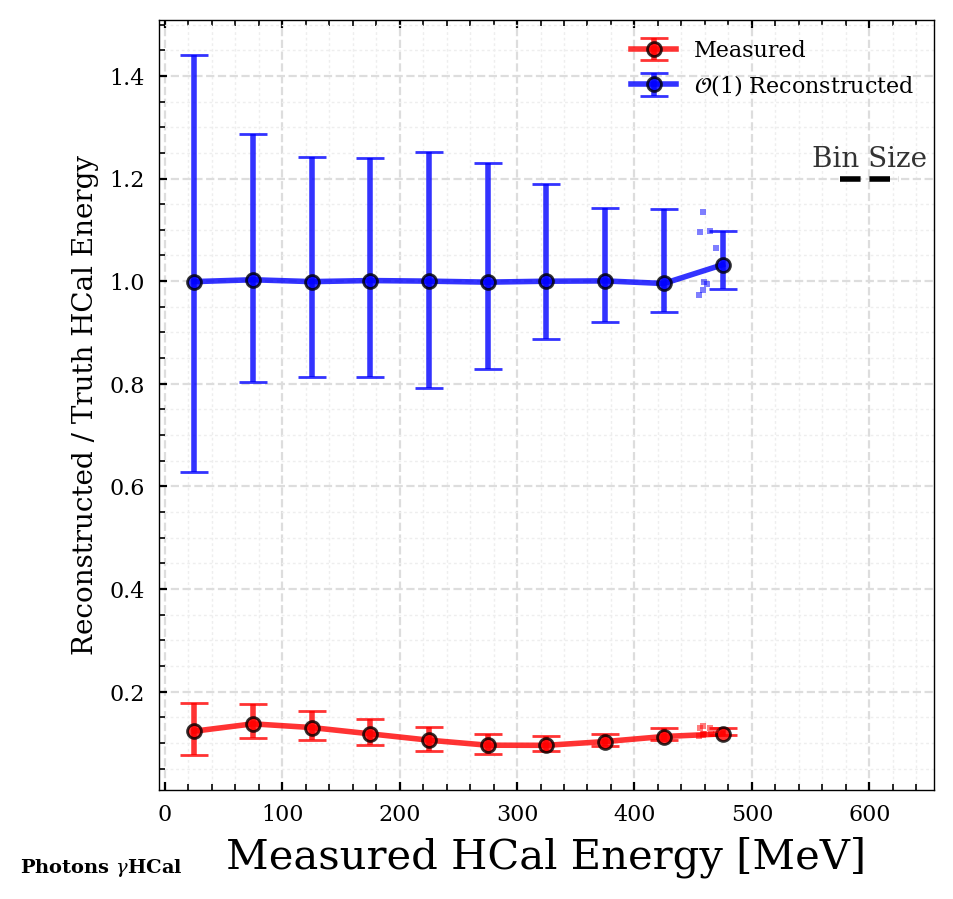

In [35]:
pho_energy_bins_hcal, pho_o1corr_hcal = o1corr_hcal(photons_hcal, bin_size=50,
                                                    label=labels_dict['photon']+'HCal',
                                                    ecal_params=[pho_energy_bins_ecal, pho_o1corr_ecal])

In [36]:
pho_energy_bins_hcal, len(pho_energy_bins_hcal)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]), 11)

In [37]:
pho_o1corr_hcal, len(pho_o1corr_hcal)

(array([ 8.12814999,  7.27960443,  7.68240547,  8.48420715,  9.47431278,
        10.44567299, 10.46855545,  9.72650146,  8.87418842,  8.49231339]),
 10)

### Non Ecal corrected particles

#### Neutrons

Axes limits [0, 800] and [0, 100]


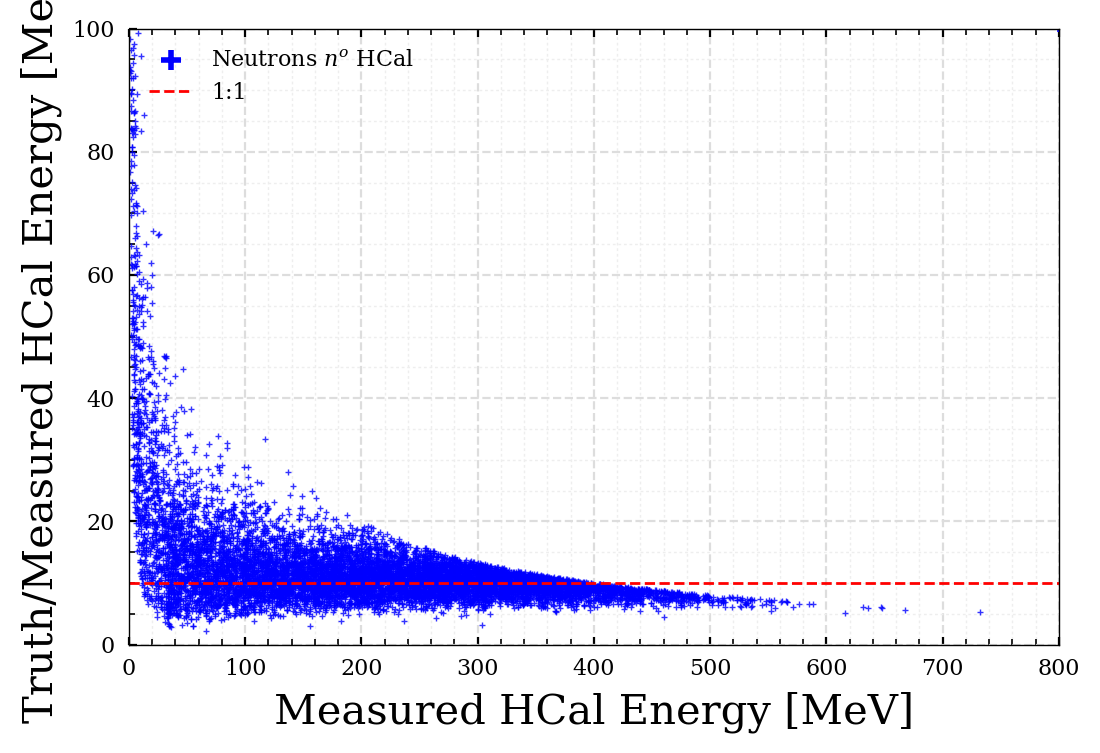

In [38]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plotting.scatter(fig, ax,
                 neutrons_hcal.get('PFCandidates_hcalEnergy'),
                 neutrons_hcal.get('PFTruthHcal_energy')/neutrons_hcal.get('PFCandidates_hcalEnergy'),
                 xlim=[0, 800], ylim=[0, 100],
                 label=labels_dict['neutron']+' HCal',
                 draw_line=True, line_prop = [None, lambda x: [10]*len(x), 1, '--', 'red', '1:1'],
                 xlabel = 'Measured HCal Energy [MeV]', ylabel = 'Truth/Measured HCal Energy [MeV]')

(9994,) (9994,)
(9987,) (9987,)
(12,) (12,) (12,)
Average energy correction is 10.430161635080973:
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600.]
[20.69665146 12.09429502 11.27052307 10.75302887 10.78688526 10.31431437
  9.7699976   9.16780472  8.53408146  7.73670673  7.12850904  6.90914202]
(9999,) (9999,)
(9999,) (9999,)
(8,) (8,) (8,)
(9992,) (9992,)
(9992,) (9992,)
(8,) (8,) (8,)
(9999,) (9999,)
(9992,) (9992,)
(12,) (12,) (12,)
(9992,) (9992,)
(9926,) (9926,)
(12,) (12,) (12,)
[20.69665146 12.09429502 11.27052307 10.75302887 10.78688526 10.31431437
  9.7699976   9.16780472  8.53408146  7.73670673  7.12850904  6.90914202] 10.430161635080973


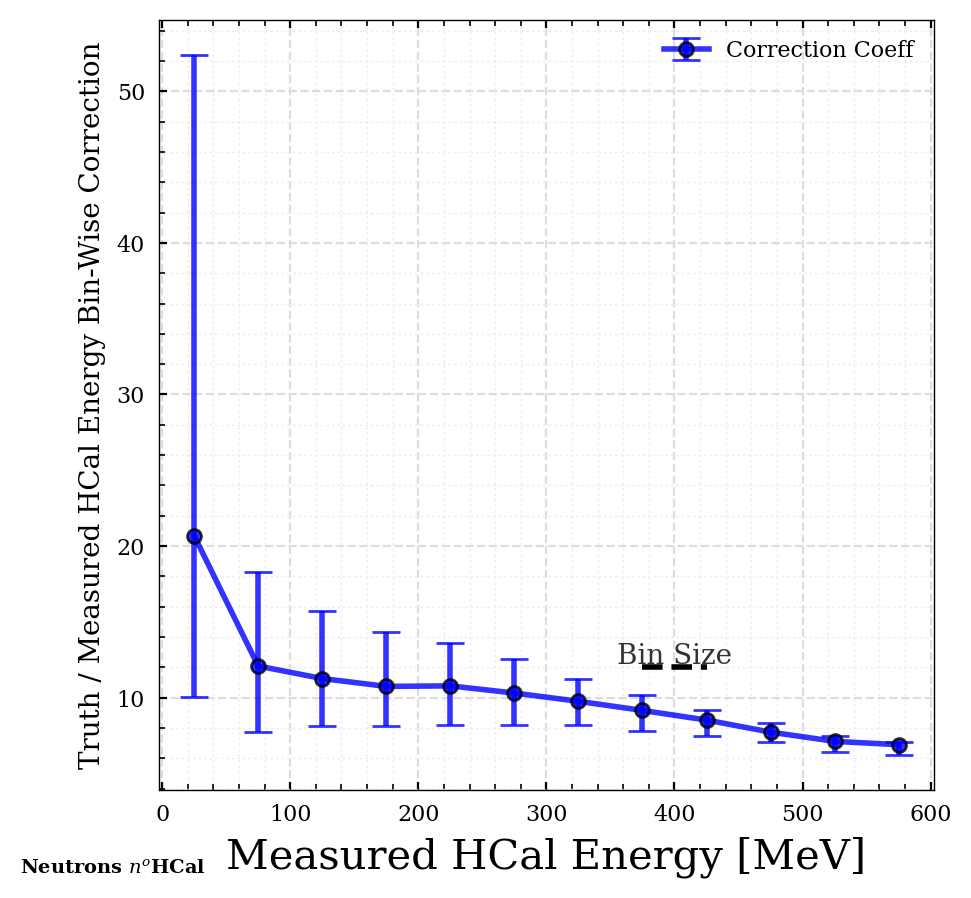

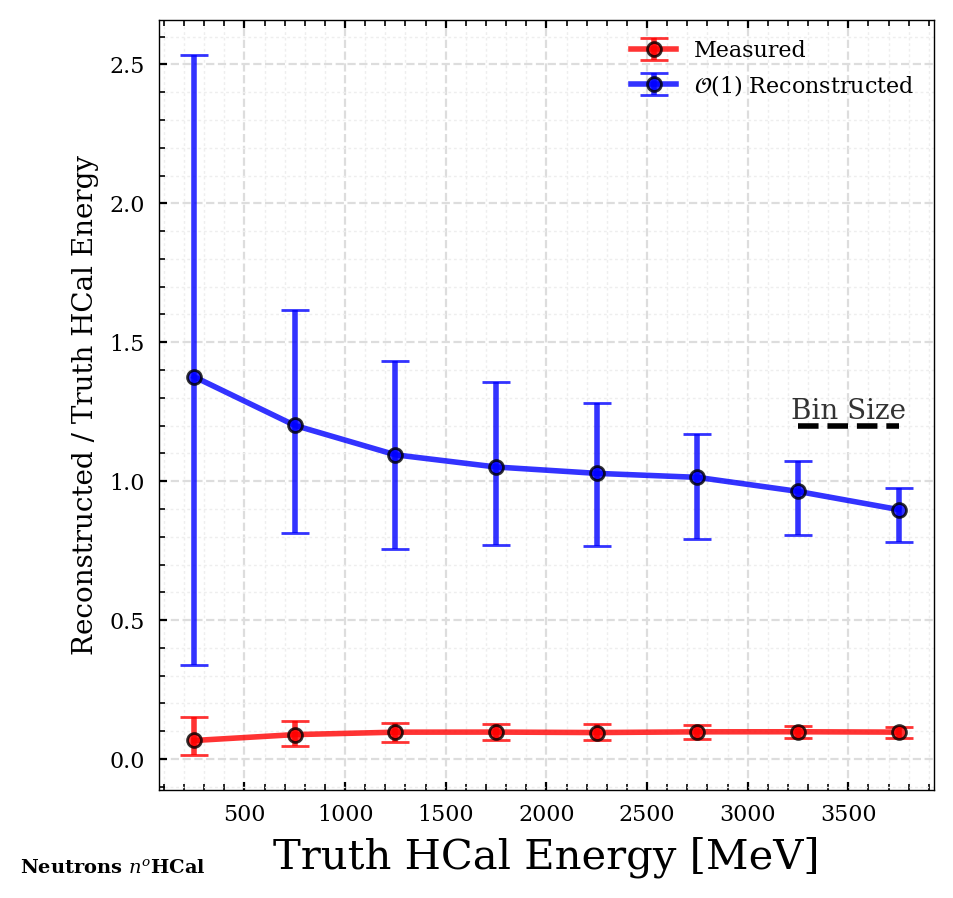

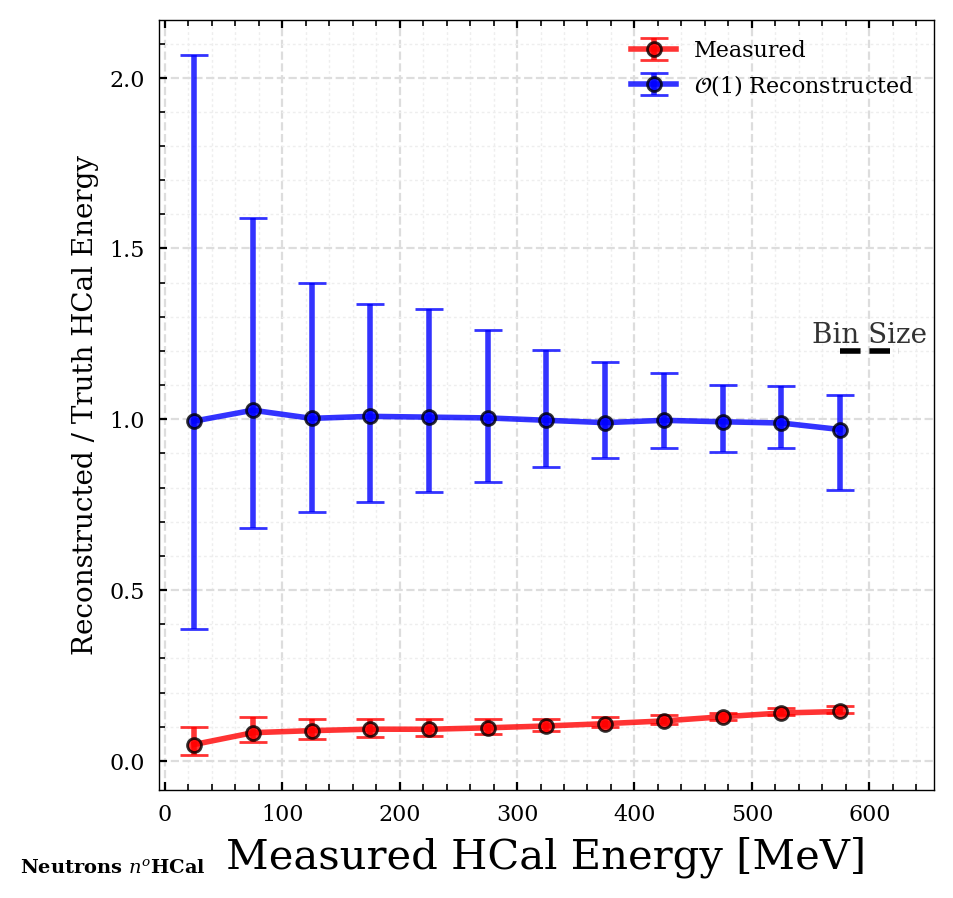

In [39]:
neu_energy_bins_hcal, neu_o1corr_hcal = o1corr_hcal(neutrons_hcal, bin_size=50,
                                                    label=labels_dict['neutron']+'HCal',
                                                    ecal_params=[[0, 1e10], [1]])  # no corrections at all
print(neu_o1corr_hcal, np.mean(neu_o1corr_hcal))

#### Pions

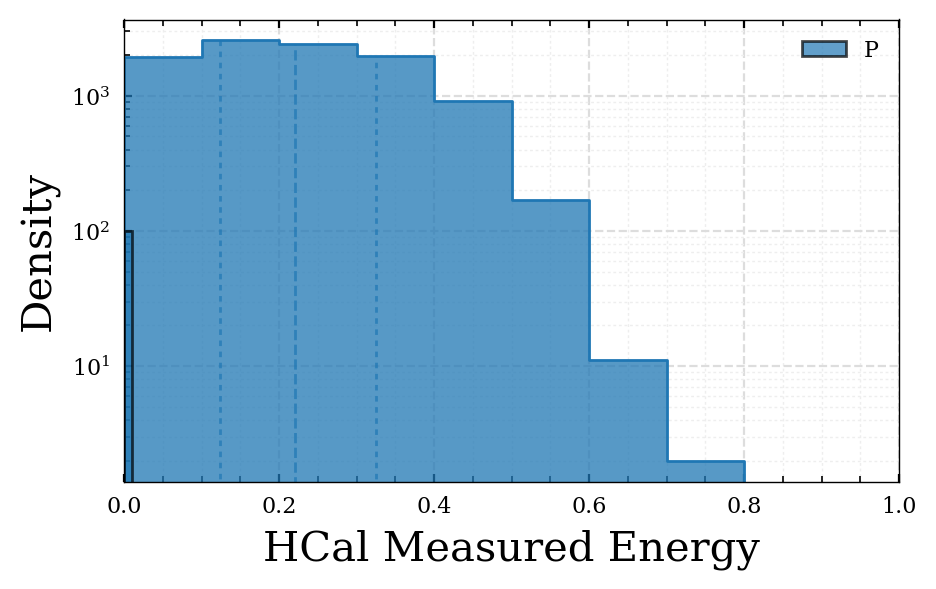

In [40]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
plotting.hist(fig, ax, pions_hcal.get('PFCandidates_hcalEnergy')/1e3, labels_dict['pion_hcal'], binwidth=0.1,
              xlim=[0, 1],
              draw_median=True, draw_quartiles=True,
              xlabel='HCal Measured Energy', ylabel='Density')
ax.set_yscale('log')
ax.legend()
plt.show()

Axes limits [0, 800] and [0, 100]


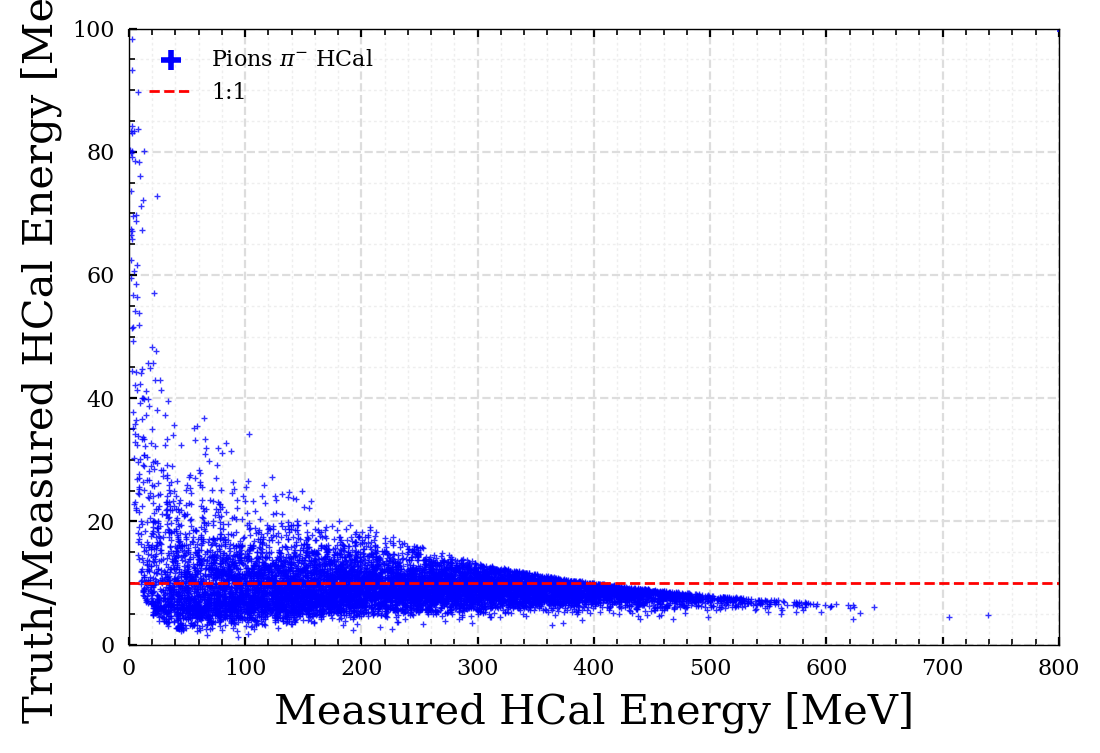

In [41]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plotting.scatter(fig, ax,
                 pions_hcal.get('PFCandidates_hcalEnergy'),
                 pions_hcal.get('PFTruthHcal_energy')/pions_hcal.get('PFCandidates_hcalEnergy'),
                 xlim=[0, 800], ylim=[0, 100],
                 label=labels_dict['pion']+' HCal',
                 draw_line=True, line_prop = [None, lambda x: [10]*len(x), 1, '--', 'red', '1:1'],
                 xlabel = 'Measured HCal Energy [MeV]', ylabel = 'Truth/Measured HCal Energy [MeV]')

(9996,) (9996,)
(9992,) (9992,)
(13,) (13,) (13,)
Average energy correction is 8.51553071462191:
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600. 650.]
[11.40357971  8.65696907  8.89711761  9.21751165  9.43256569  9.26484966
  9.09767485  8.80322123  8.30389881  7.67658615  7.13891768  6.58217096
  6.2268362 ]
(9999,) (9999,)
(9999,) (9999,)
(8,) (8,) (8,)
(9997,) (9997,)
(9997,) (9997,)
(8,) (8,) (8,)
(9999,) (9999,)
(9995,) (9995,)
(13,) (13,) (13,)
(9997,) (9997,)
(9900,) (9900,)
(14,) (14,) (14,)
[11.40357971  8.65696907  8.89711761  9.21751165  9.43256569  9.26484966
  9.09767485  8.80322123  8.30389881  7.67658615  7.13891768  6.58217096
  6.2268362 ] 8.51553071462191


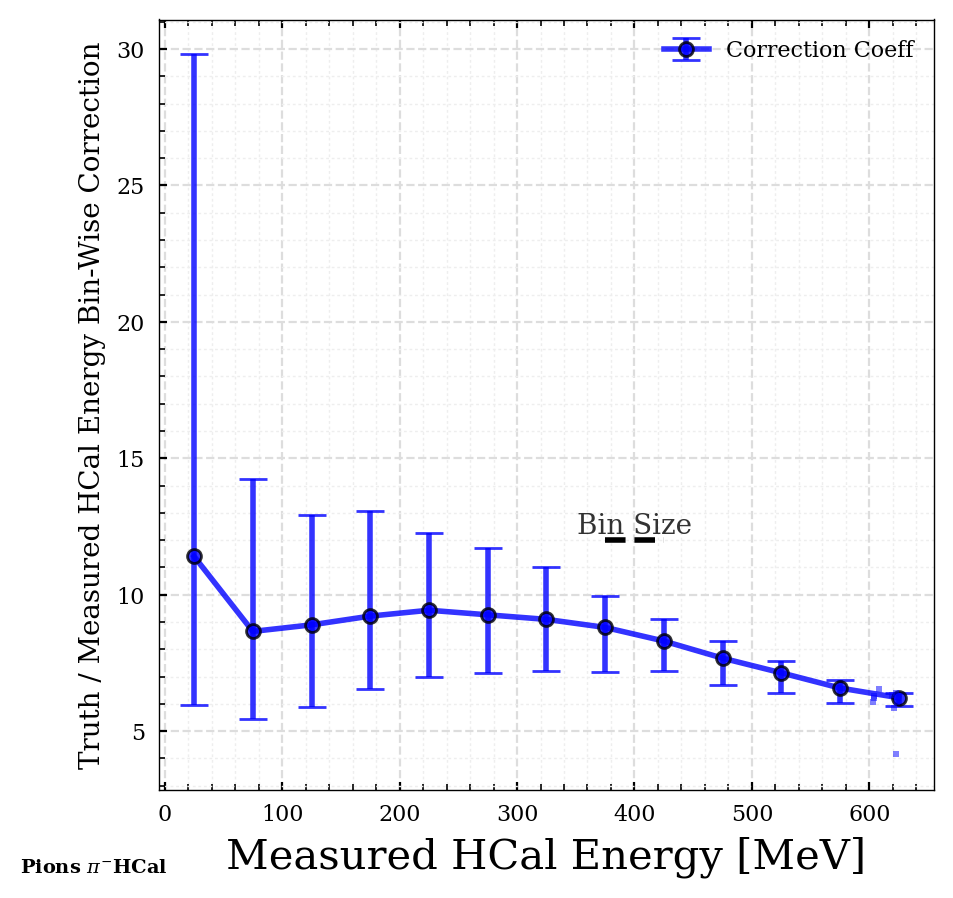

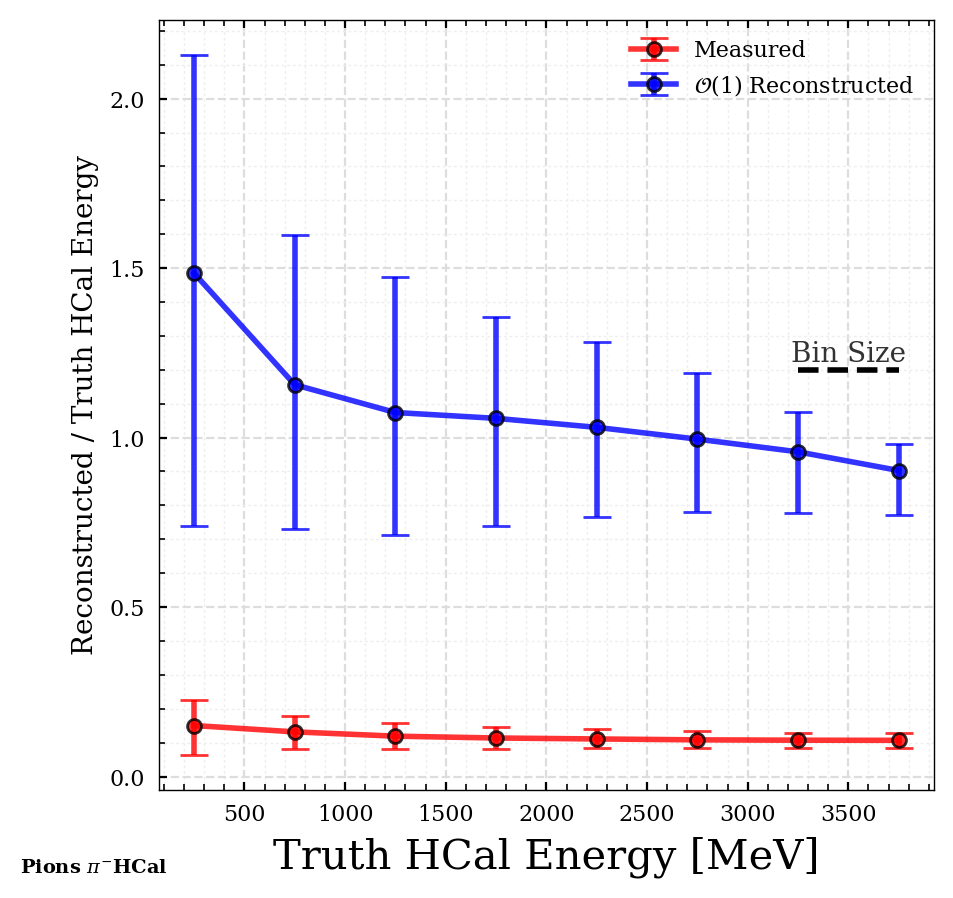

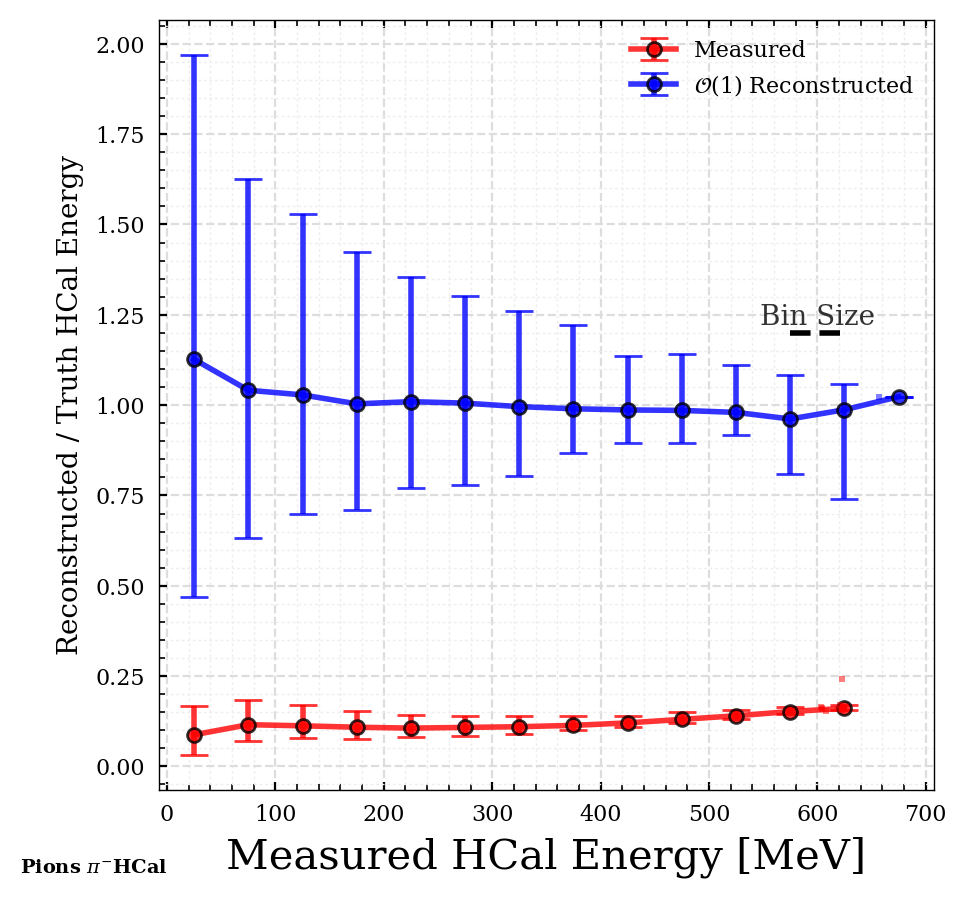

In [42]:
pim_energy_bins_hcal, pim_o1corr_hcal = o1corr_hcal(pions_hcal, bin_size=50,
                                                    label=labels_dict['pion']+'HCal',
                                                    ecal_params=[[0, 1e10], [1]])  # no corrections at all
print(pim_o1corr_hcal, np.mean(pim_o1corr_hcal))

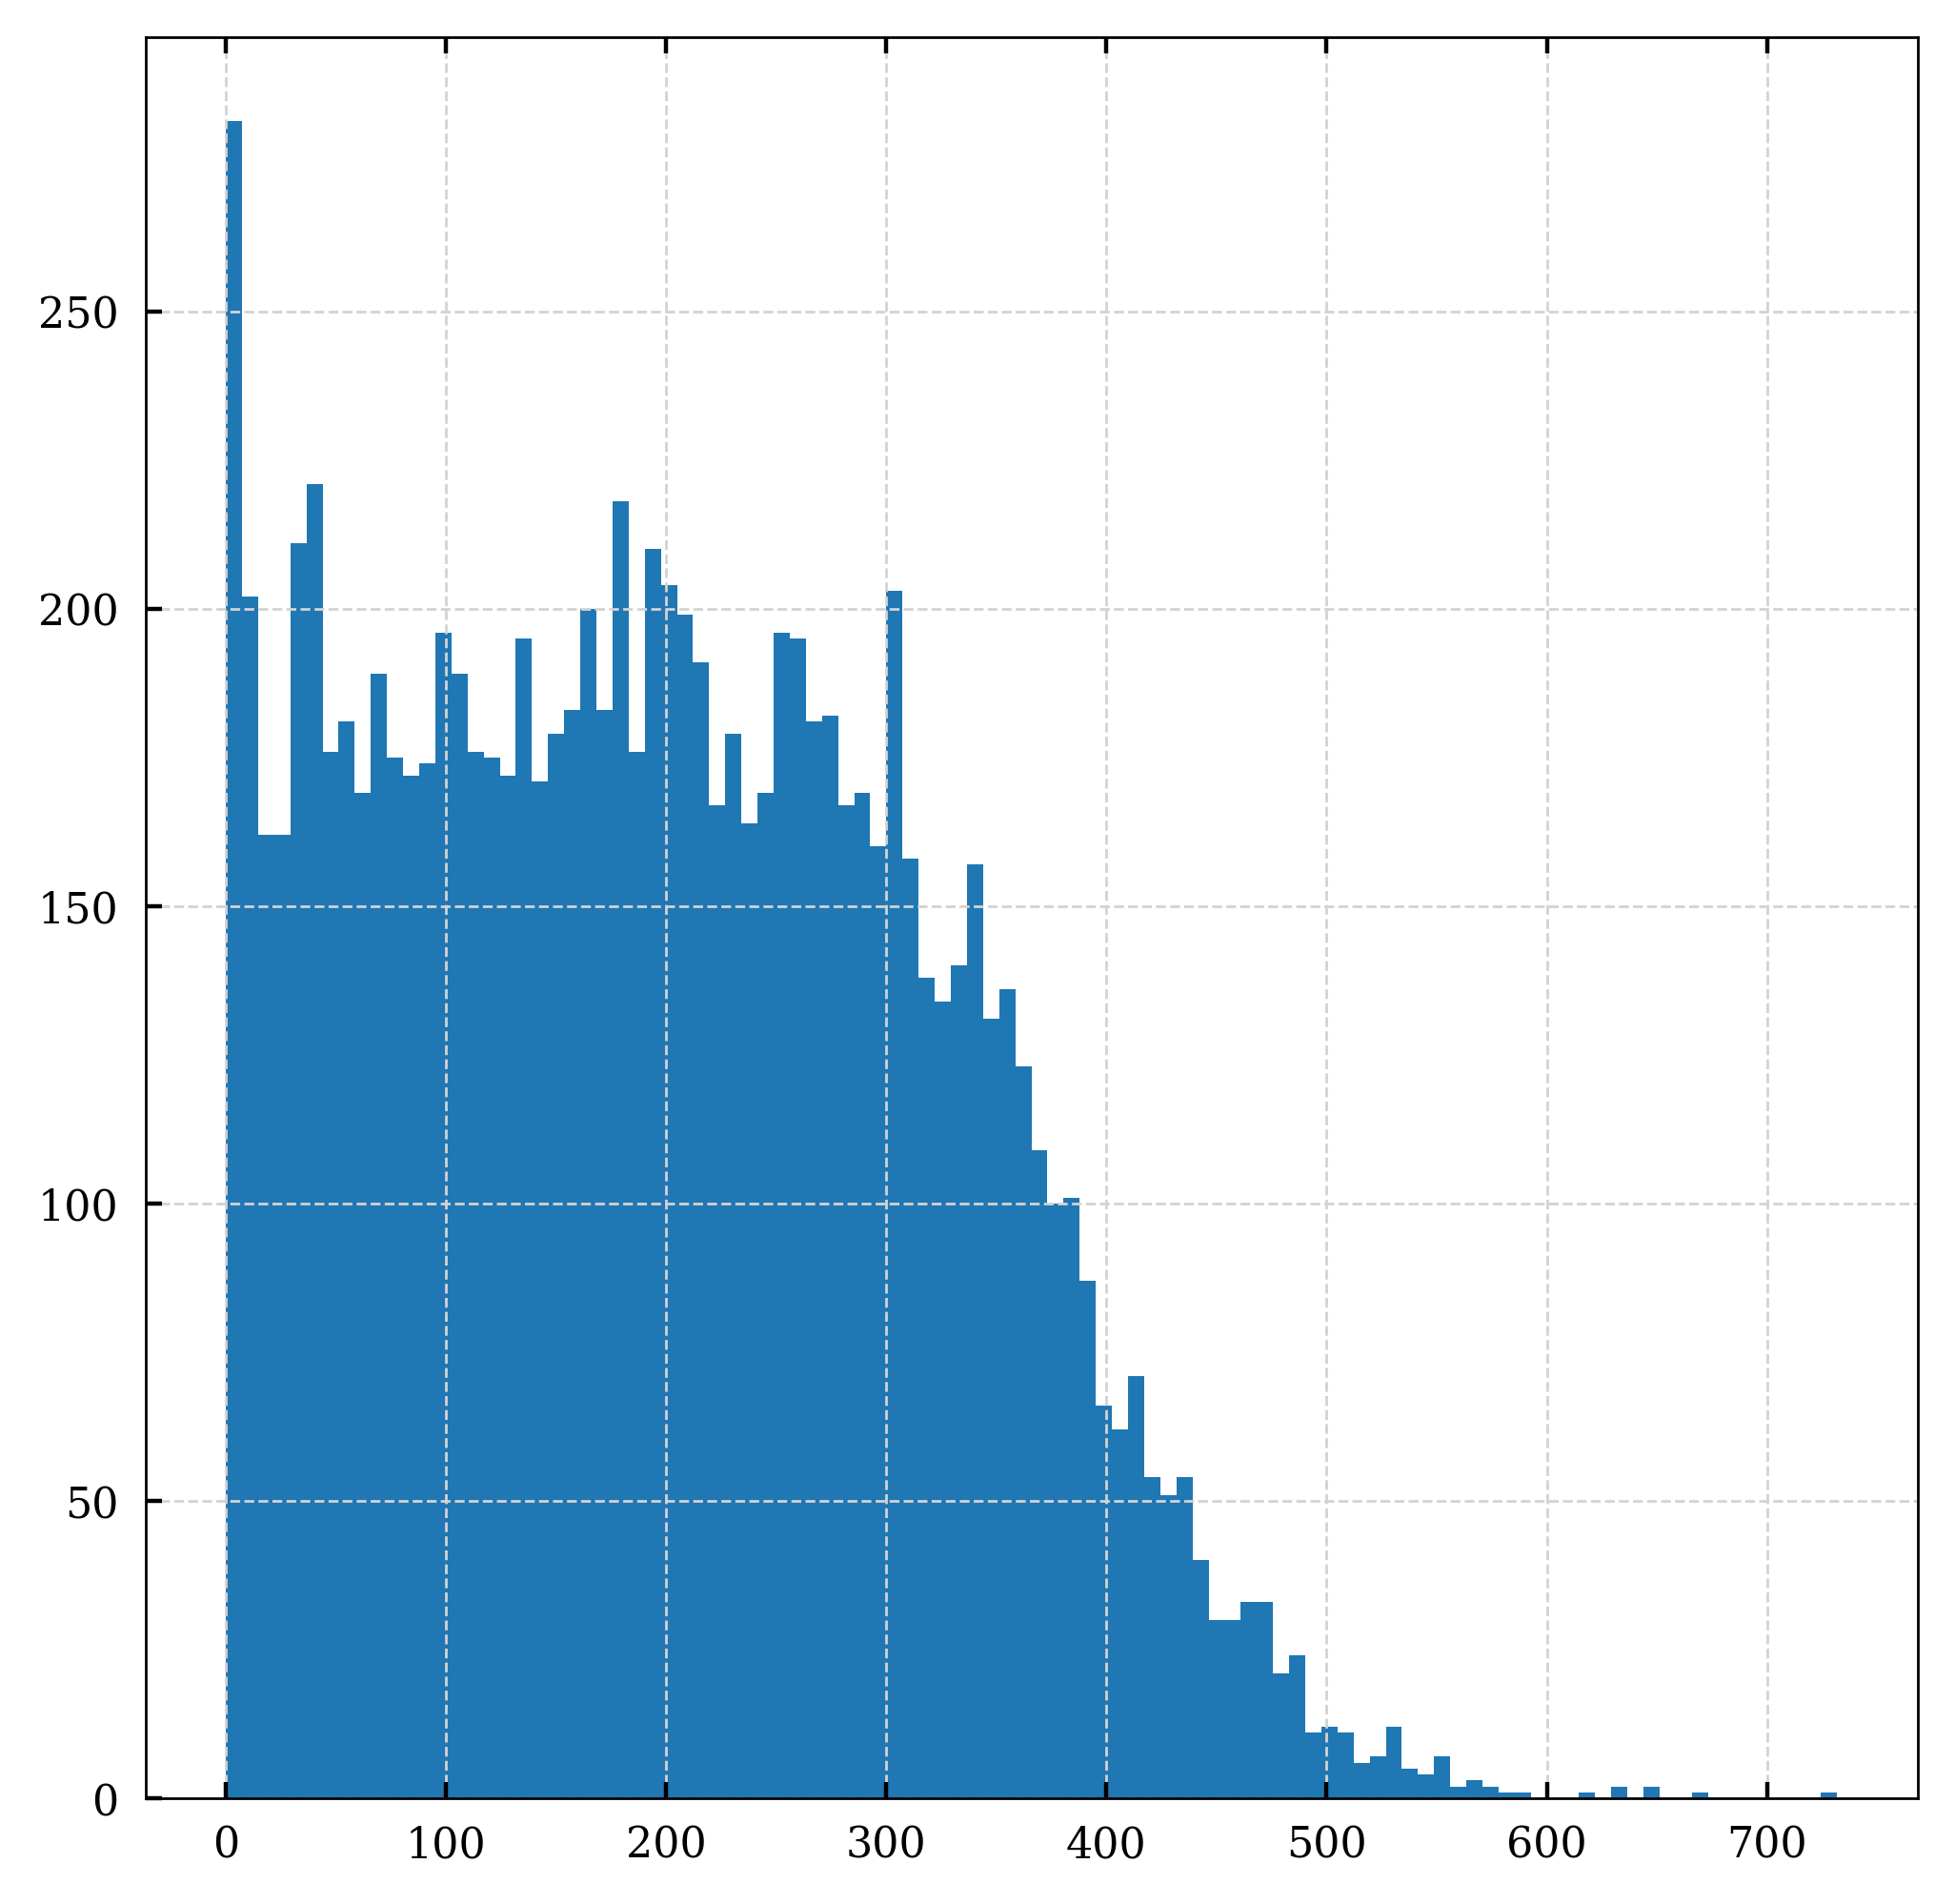

In [43]:
plt.hist(neutrons_hcal.get('PFCandidates_hcalEnergy'))
plt.show()

#### Protons

Axes limits [0, 800] and [0, 100]


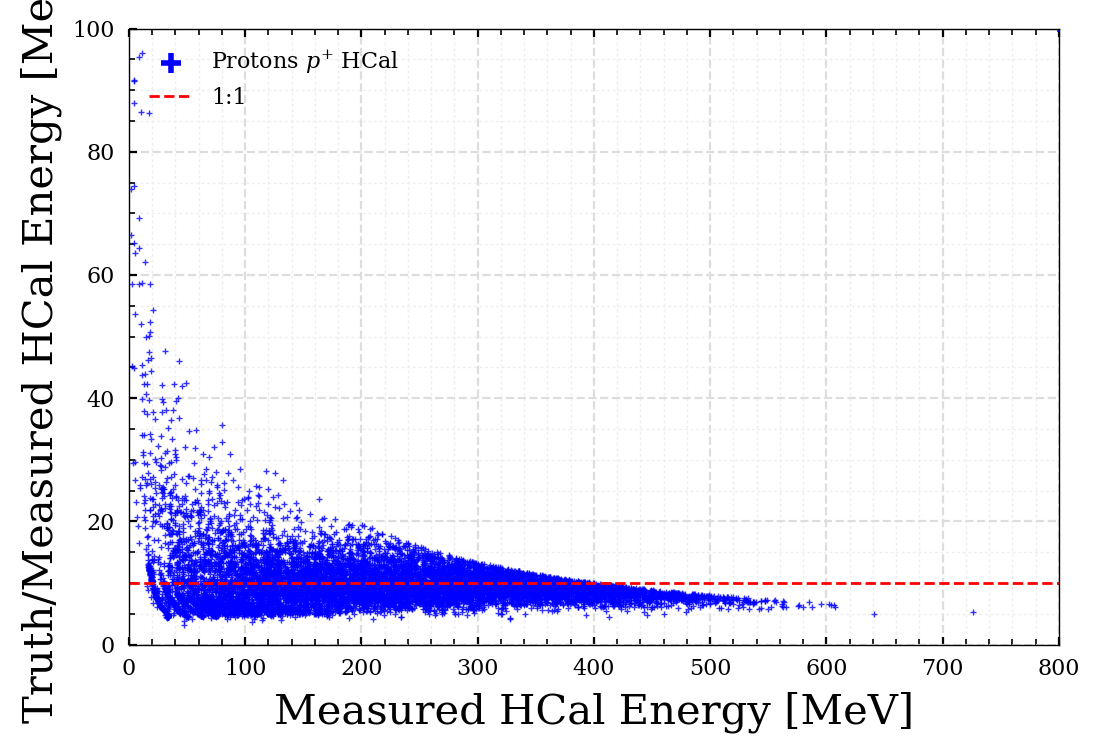

In [44]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plotting.scatter(fig, ax,
                 protons_hcal.get('PFCandidates_hcalEnergy'),
                 protons_hcal.get('PFTruthHcal_energy')/protons_hcal.get('PFCandidates_hcalEnergy'),
                 xlim=[0, 800], ylim=[0, 100],
                 label=labels_dict['proton']+' HCal',
                 draw_line=True, line_prop = [None, lambda x: [10]*len(x), 1, '--', 'red', '1:1'],
                 xlabel = 'Measured HCal Energy [MeV]', ylabel = 'Truth/Measured HCal Energy [MeV]')

(9898,) (9898,)
(9892,) (9892,)
(12,) (12,) (12,)
Average energy correction is 8.94060375293096:
[  0.  50. 100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600.]
[10.84956312  9.25769329  9.72972488  9.88422489  9.89008617  9.64541388
  9.41108131  8.89256859  8.39314938  7.75644255  7.10567379  6.47162318]
(10000,) (10000,)
(10000,) (10000,)
(8,) (8,) (8,)
(9994,) (9994,)
(9994,) (9994,)
(8,) (8,) (8,)
(10000,) (10000,)
(9994,) (9994,)
(12,) (12,) (12,)
(9994,) (9994,)
(9941,) (9941,)
(13,) (13,) (13,)
[10.84956312  9.25769329  9.72972488  9.88422489  9.89008617  9.64541388
  9.41108131  8.89256859  8.39314938  7.75644255  7.10567379  6.47162318] 8.94060375293096


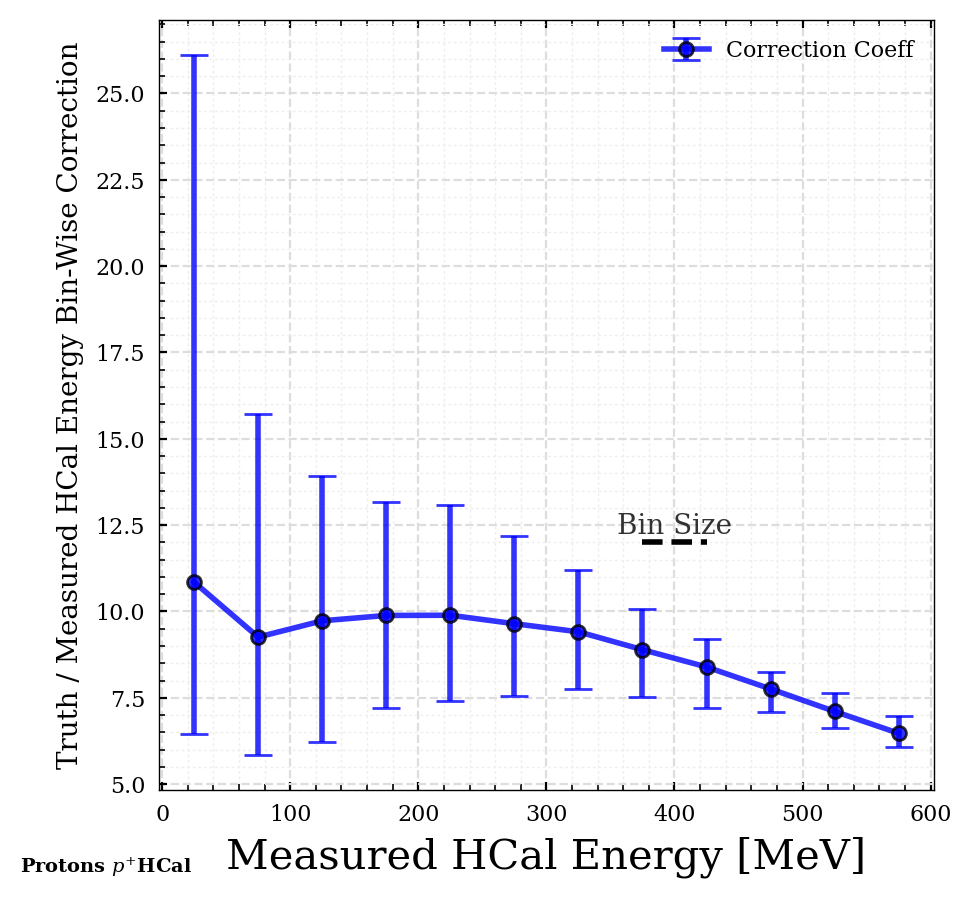

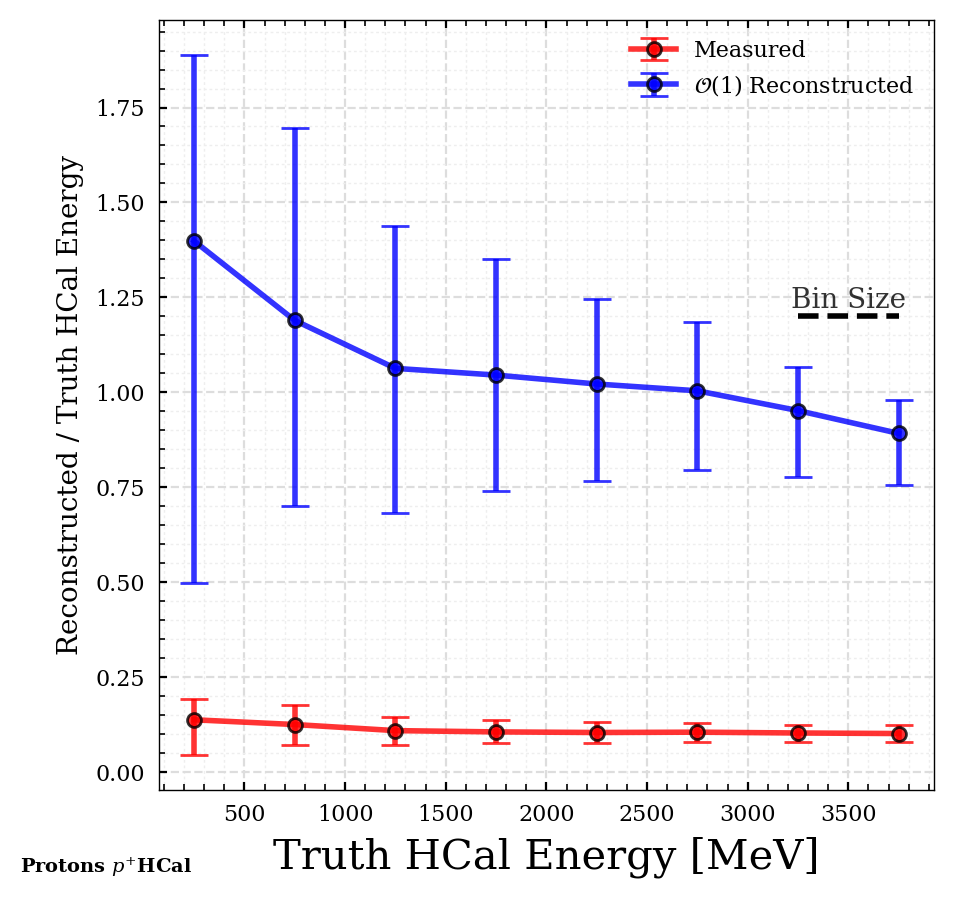

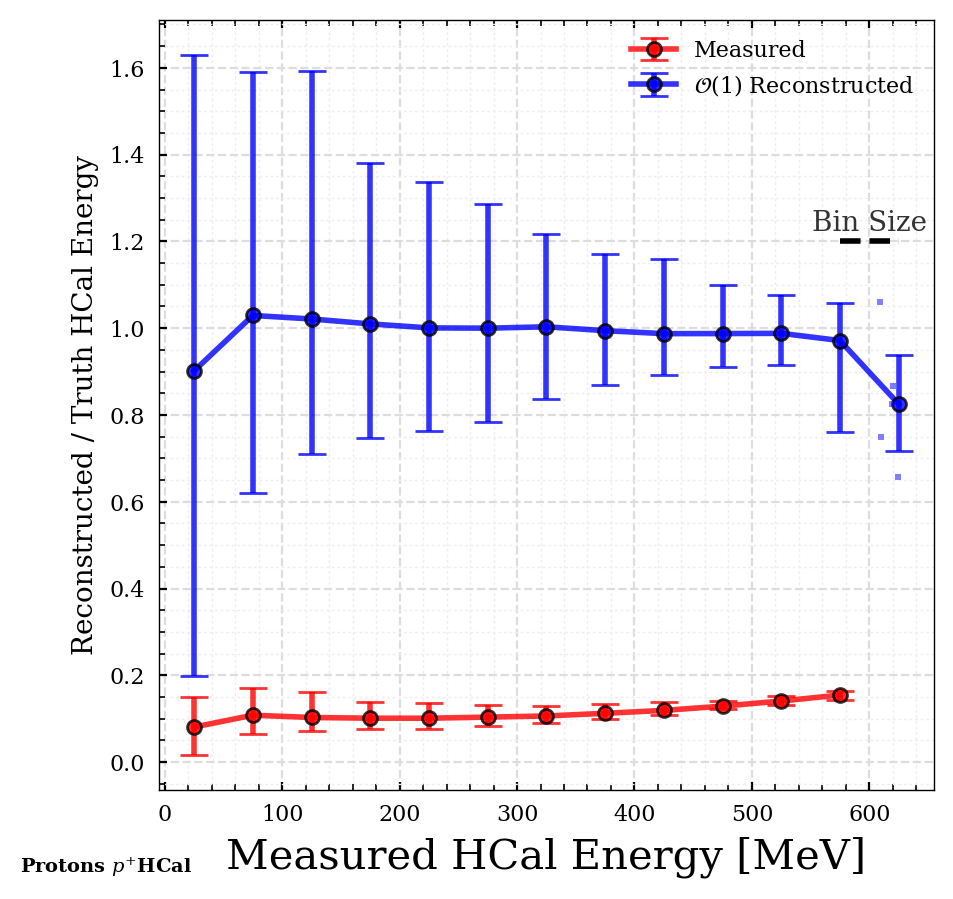

In [45]:
pro_energy_bins_hcal, pro_o1corr_hcal = o1corr_hcal(protons_hcal, bin_size=50,
                                                    label=labels_dict['proton']+'HCal',
                                                    ecal_params=[[0, 1e10], [1]])  # no corrections at all
print(pro_o1corr_hcal, np.mean(pro_o1corr_hcal))

## Summary: ECal & HCal calibrations

`ele_energy_bins_ecal`, `pho_energy_bins_ecal`

`ele_o1corr_ecal`

`pho_o1corr_ecal`

-----

`ele_energy_bins_hcal`, `pho_energy_bins_hcal`

`ele_o1corr_hcal`

`pho_o1corr_hcal`

### ECal coefficients

In [46]:
ele_energy_bins_ecal, ele_o1corr_ecal

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.]),
 array([1.18598557, 1.00625324, 0.97645277, 0.96624851, 0.97098845,
        0.95967686, 0.95366329, 0.92554763, 0.86182195, 0.7882978 ,
        0.71596402, 0.65569708]))

In [47]:
pho_energy_bins_ecal, pho_o1corr_ecal

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.]),
 array([1.19377148, 1.05279595, 1.01311707, 1.00635087, 0.99447447,
        0.99247414, 0.97390121, 0.95206821, 0.88605094, 0.81365258,
        0.73887473, 0.67134774]))

### HCal coefficients

In [48]:
ele_energy_bins_hcal, ele_o1corr_hcal

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 array([ 8.72792101,  7.47605658,  7.8331418 ,  8.58382893,  9.46359539,
        10.44721127, 10.46484852,  9.68849564,  8.86627007,  8.00884438]))

In [49]:
pho_energy_bins_hcal, pho_o1corr_hcal

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 array([ 8.12814999,  7.27960443,  7.68240547,  8.48420715,  9.47431278,
        10.44567299, 10.46855545,  9.72650146,  8.87418842,  8.49231339]))

In [50]:
neu_energy_bins_hcal, neu_o1corr_hcal

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600.]),
 array([20.69665146, 12.09429502, 11.27052307, 10.75302887, 10.78688526,
        10.31431437,  9.7699976 ,  9.16780472,  8.53408146,  7.73670673,
         7.12850904,  6.90914202]))

In [51]:
pim_energy_bins_hcal, pim_o1corr_hcal

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650.]),
 array([11.40357971,  8.65696907,  8.89711761,  9.21751165,  9.43256569,
         9.26484966,  9.09767485,  8.80322123,  8.30389881,  7.67658615,
         7.13891768,  6.58217096,  6.2268362 ]))

In [52]:
pro_energy_bins_hcal, pro_o1corr_hcal

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600.]),
 array([10.84956312,  9.25769329,  9.72972488,  9.88422489,  9.89008617,
         9.64541388,  9.41108131,  8.89256859,  8.39314938,  7.75644255,
         7.10567379,  6.47162318]))

### Extending & Mean Corrections

In [53]:
o1corr_arr = [
    [ele_energy_bins_hcal, ele_o1corr_hcal],
    [pho_energy_bins_hcal, pho_o1corr_hcal],
    [neu_energy_bins_hcal, neu_o1corr_hcal],
    [pim_energy_bins_hcal, pim_o1corr_hcal],
    [pro_energy_bins_hcal, pro_o1corr_hcal]
]
names_arr = 'electron photon neutron pion proton'.split(' ')

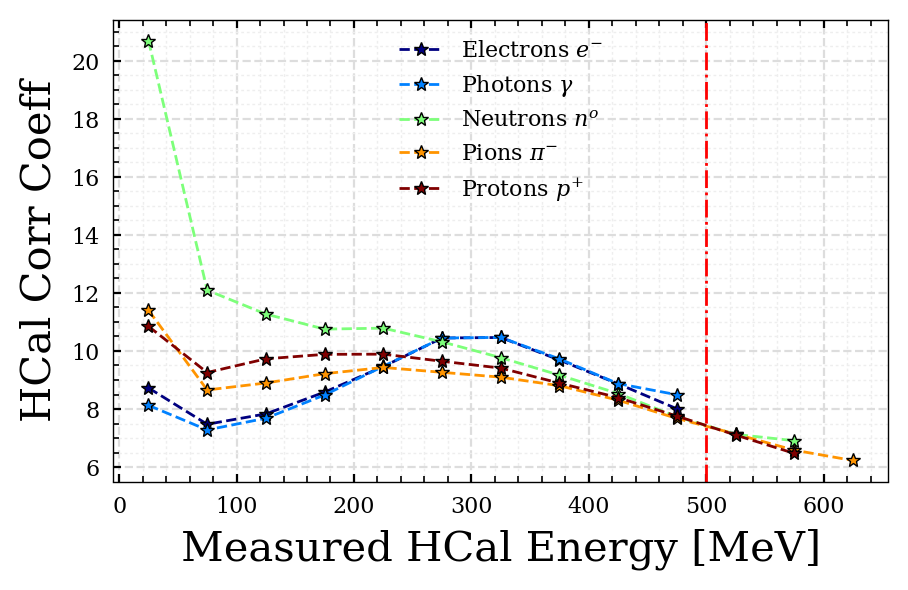

In [54]:
# make a line at HCal measurement = 500
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
plotting.grid(ax)
# plot the hcal corrections
from matplotlib import cm
colors = cm.jet(np.linspace(0, 1, len(o1corr_arr)))

for i, o1corr in enumerate(o1corr_arr):
    plotting.bin_plot(fig, ax, o1corr[0], o1corr[1],
                      color=colors[i], alpha=1,
                      xlabel='Measured HCal Energy [MeV]',
                      ylabel='HCal Corr Coeff',
                      label=labels_dict[names_arr[i]])
ax.axvline(x=500, lw=1, ls='-.', c='red')
ax.legend()
plt.show()

In [55]:
def extended_mean(corr_arr):
    flip_arr = list(map(list, zip(*corr_arr)))
    bins = flip_arr[0]
    vals = flip_arr[1]
    # the largest set of bins
    bin_len = np.array([len(i) for i in bins])
    ext_bins = np.array(bins[np.argmax(bin_len)])
    # index for mapping
    ind = []
    for i, _ in enumerate(ext_bins[:-1]):
        ind.append(i < bin_len - 1)
    # extend val for each type
    ind = np.cumsum(np.transpose(ind), axis=1) - 1
    ext_vals = np.array([val[ind[j]] for j, val in enumerate(vals)])
    # average corrections for all particles
    avg_vals = np.mean(ext_vals, axis=0)
    # average corrections for only electrons and photons
    avg_vals_pe = np.mean(ext_vals[:2], axis=0)
    
    return ext_bins, ext_vals, avg_vals, avg_vals_pe
    
ext_bins_hcal, ext_o1corrs_hcal, avg_o1corr_hcal, pe_o1corr_hcal = extended_mean(o1corr_arr)

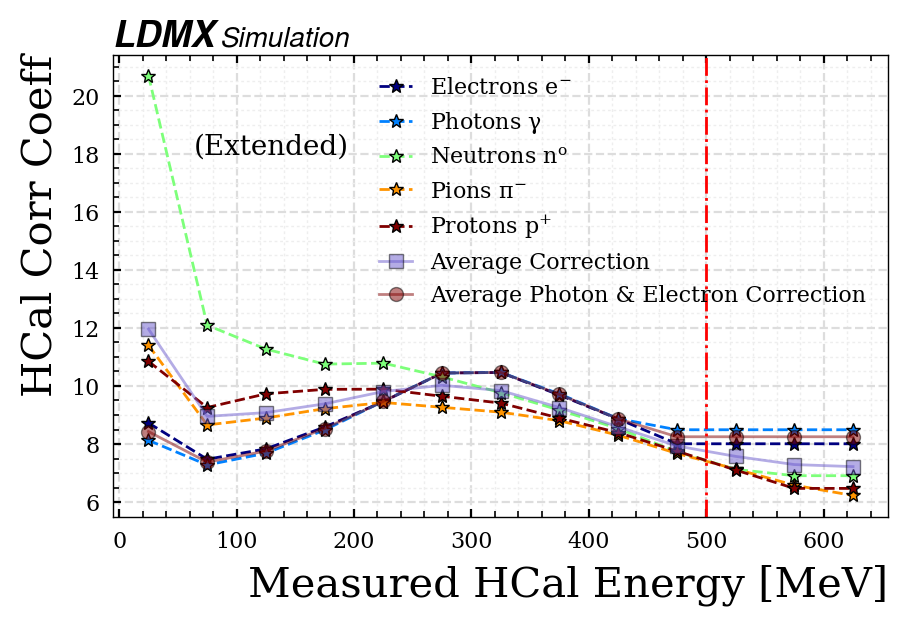

In [56]:
# make a line at HCal measurement = 500
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
plotting.style_ldmx(fig, ax)
plotting.grid(ax)
# plot the hcal corrections
from matplotlib import cm
colors = cm.jet(np.linspace(0, 1, len(o1corr_arr)))

for i, o1corr in enumerate(ext_o1corrs_hcal):
    plotting.bin_plot(fig, ax, ext_bins_hcal, o1corr,
                      color=colors[i], alpha=1,
                      xlabel='Measured HCal Energy [MeV]',
                      ylabel='HCal Corr Coeff',
                      label=labels_dict[names_arr[i]])
# avergae
plotting.bin_plot(fig, ax, ext_bins_hcal, avg_o1corr_hcal,
                  color='slateblue', fmt='s-', alpha=0.5,
                  xlabel='Measured HCal Energy [MeV]',
                  ylabel='HCal Corr Coeff',
                  label='Average Correction')
# photon & electron average
plotting.bin_plot(fig, ax, ext_bins_hcal, pe_o1corr_hcal,
                  color='maroon', fmt='o-', alpha=0.5,
                  xlabel='Measured HCal Energy [MeV]',
                  ylabel='HCal Corr Coeff',
                  label='Average Photon & Electron Correction')
ax.axvline(x=500, lw=1, ls='-.', c='red')
ax.text(130, 18, '(Extended)', ha='center')
#ax.set_yscale('log')
ax.legend()
plt.show()

In [57]:
print('ECal Corrections')
print(f'{"bins":<15}{"ele coeff":<15}{"pho coeff":<15}')
assert(np.array_equiv(ele_energy_bins_ecal, pho_energy_bins_ecal))
for ebin, ecorr, gcorr in zip(ele_energy_bins_ecal, ele_o1corr_ecal, pho_o1corr_ecal):
    print(f'{ebin:<15.2f}{ecorr:<15.2f}{gcorr:<15.2f}')

print('-' * 20)

print('HCal Corrections')
print(f'{"bins":<15}{"ele coeff":<15}{"pho coeff":<15}')
assert(np.array_equiv(ele_energy_bins_hcal, pho_energy_bins_hcal))
for ebin, ecorr, gcorr in zip(ele_energy_bins_hcal, ele_o1corr_hcal, pho_o1corr_hcal):
    print(f'{ebin:<15.2f}{ecorr:<15.2f}{gcorr:<15.2f}')

ECal Corrections
bins           ele coeff      pho coeff      
0.00           1.19           1.19           
500.00         1.01           1.05           
1000.00        0.98           1.01           
1500.00        0.97           1.01           
2000.00        0.97           0.99           
2500.00        0.96           0.99           
3000.00        0.95           0.97           
3500.00        0.93           0.95           
4000.00        0.86           0.89           
4500.00        0.79           0.81           
5000.00        0.72           0.74           
5500.00        0.66           0.67           
--------------------
HCal Corrections
bins           ele coeff      pho coeff      
0.00           8.73           8.13           
50.00          7.48           7.28           
100.00         7.83           7.68           
150.00         8.58           8.48           
200.00         9.46           9.47           
250.00         10.45          10.45          
300.00         10.46     

## Applying to other particles

The range of ecal and hcal measurements should be similar for all particle species, since they roughly had the same energy composition.

In [58]:
print(names_arr)
len(ext_bins_hcal), ext_o1corrs_hcal.shape, len(avg_o1corr_hcal), len(pe_o1corr_hcal)

['electron', 'photon', 'neutron', 'pion', 'proton']


(14, (5, 13), 13, 13)

In [59]:
# ecal is only electrons & photons
avg_o1corr_ecal = np.mean([ele_o1corr_ecal, pho_o1corr_ecal], axis=0)
avg_o1corr_ecal

array([1.18987852, 1.02952459, 0.99478492, 0.98629969, 0.98273146,
       0.9760755 , 0.96378225, 0.93880792, 0.87393644, 0.80097519,
       0.72741938, 0.66352241])

In [60]:
# scheme = 'nearest'
scheme = 'spline'

### Electrons & Photons

#### Average

In [61]:
ele_energy_bins_ecal, avg_o1corr_ecal, ext_bins_hcal, pe_o1corr_hcal

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.]),
 array([1.18987852, 1.02952459, 0.99478492, 0.98629969, 0.98273146,
        0.9760755 , 0.96378225, 0.93880792, 0.87393644, 0.80097519,
        0.72741938, 0.66352241]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650.]),
 array([ 8.4280355 ,  7.37783051,  7.75777364,  8.53401804,  9.46895409,
        10.44644213, 10.46670198,  9.70749855,  8.87022924,  8.25057888,
         8.25057888,  8.25057888,  8.25057888]))

HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(9965,) (9965,)
(9965,) (9965,)
(19,) (19,) (19,)
(9965,) (9965,)
(9965,) (9965,)
(19,) (19,) (19,)
HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(9378,) (9378,)
(9378,) (9378,)
(19,) (19,) (19,)
(9378,) (9378,)
(9378,) (9378,)
(19,) (19,) (19,)


(array([ 848.20860187, 3378.21401351, 2189.67325666, ...,  529.13885138,
        1598.30882393,  700.59265157]),
 array([ 0.        , 12.38338943,  0.        , ..., 19.5152895 ,
         0.        ,  0.        ]),
 array([ 848.20860187, 3390.59740294, 2189.67325666, ...,  548.65414088,
        1598.30882393,  700.59265157]))

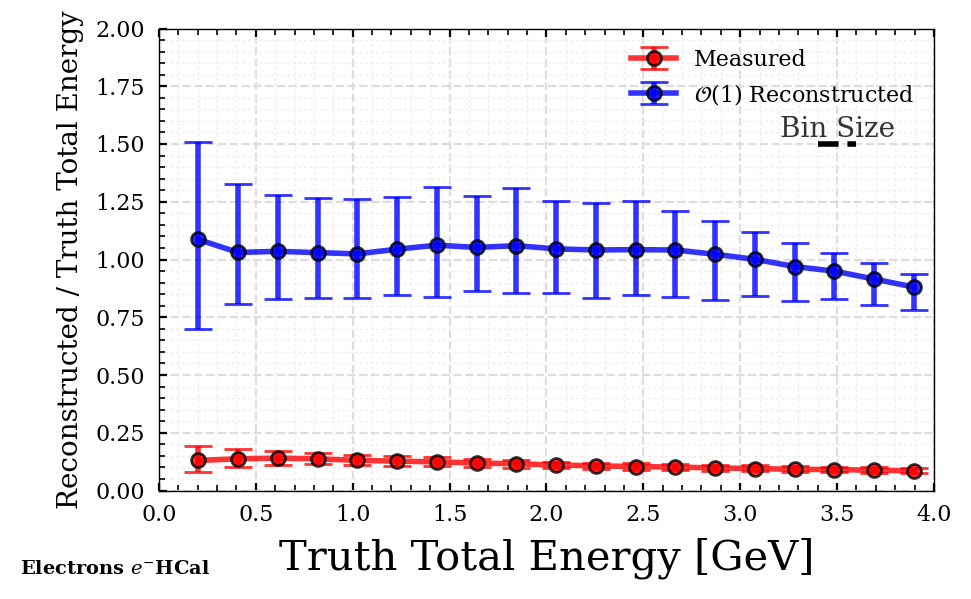

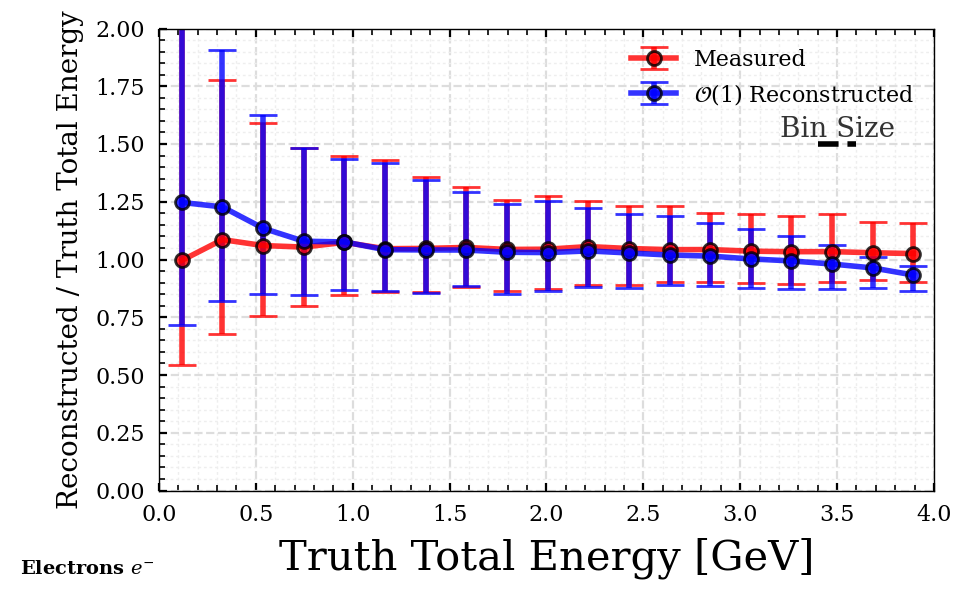

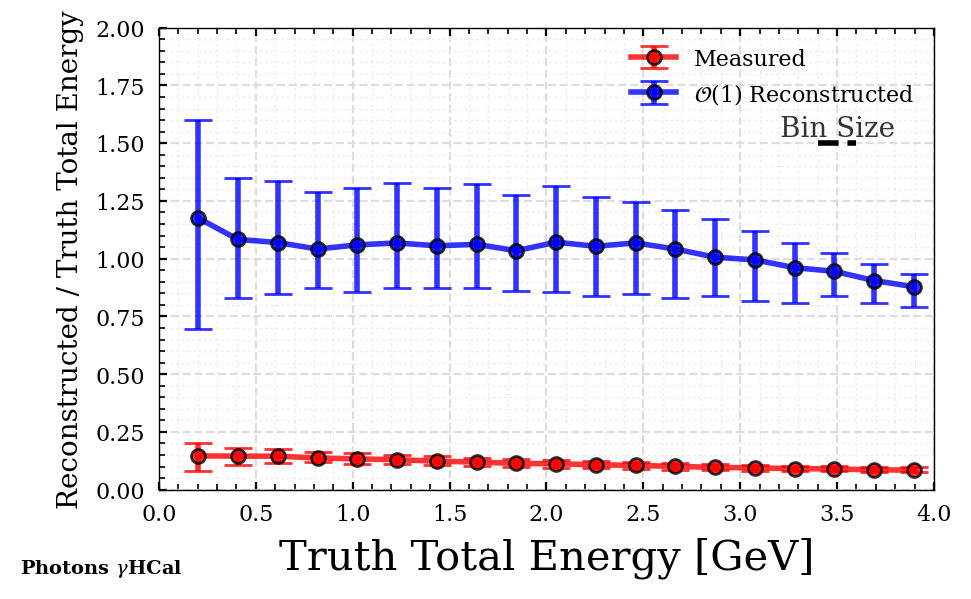

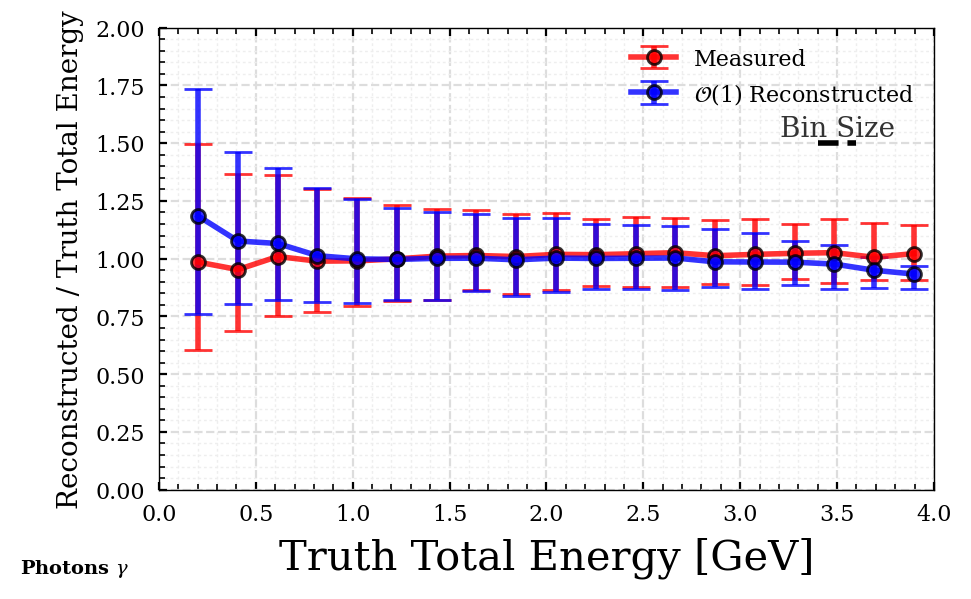

In [62]:
electrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                             energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                             scheme=scheme, label=labels_dict['electron']+'HCal')
electrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                        energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                        scheme=scheme, label=labels_dict['electron'])
photons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                           scheme=scheme, label=labels_dict['photon']+'HCal')
photons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                      scheme=scheme, label=labels_dict['photon'])

#### Per-Particle

In [63]:
# electrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                              energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[0],
#                              scheme=scheme, label=labels_dict['electron']+'HCal')
# electrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                         energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[0],
#                         scheme=scheme, label=labels_dict['electron'])
# photons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                            energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[1],
#                            scheme=scheme, label=labels_dict['photon']+'HCal')
# photons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                       energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[1],
#                       scheme=scheme, label=labels_dict['photon'])

### Other particles

#### Average

HCal energy set to truth
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
Target energy set to truth
(9881,) (9881,)
(9881,) (9881,)
(19,) (19,) (19,)
(9881,) (9881,)
(9881,) (9881,)
(19,) (19,) (19,)
HCal energy set to truth
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
Target energy set to truth
(9873,) (9873,)
(9873,) (9873,)
(19,) (19,) (19,)
(9873,) (9873,)
(9873,) (9873,)
(19,) (19,) (19,)
HCal energy set to truth
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
Target energy set to truth
(9902,) (9902,)
(9902,) (9902,)
(19,) (19,) (19,)
(9902,) (9902,)
(9902,) (9902,)
(19,) (19,) (19,)


(array([ 953.31775534, 2274.83179733, 2216.95842701, ..., 1198.10623341,
         781.19022399,  404.31143089]),
 array([   2.10689739,  568.5480087 ,   38.62092111, ...,    0.        ,
           0.        , 1416.00674663]),
 array([ 955.42465272, 2843.37980603, 2255.57934813, ..., 1198.10623341,
         781.19022399, 1820.31817753]))

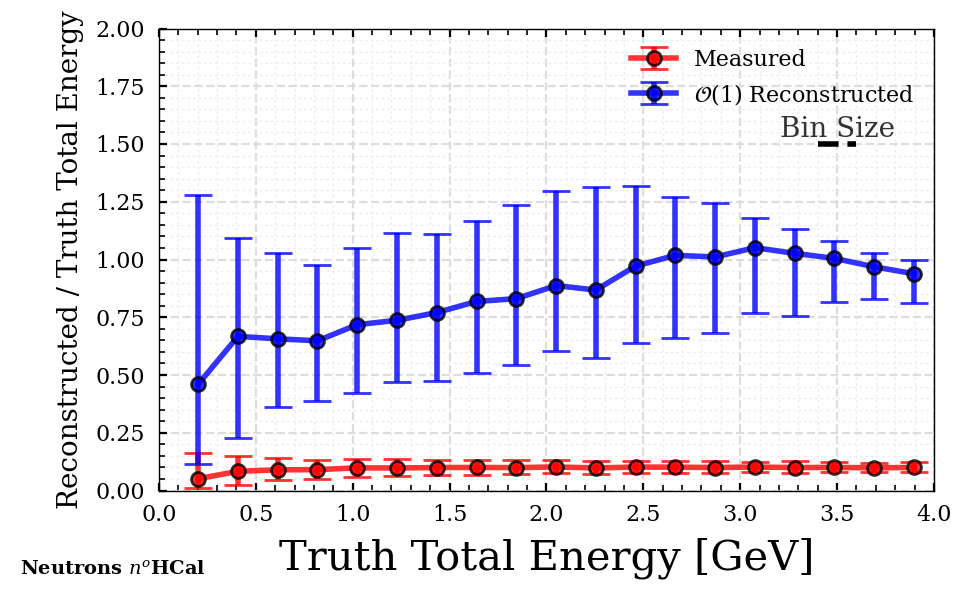

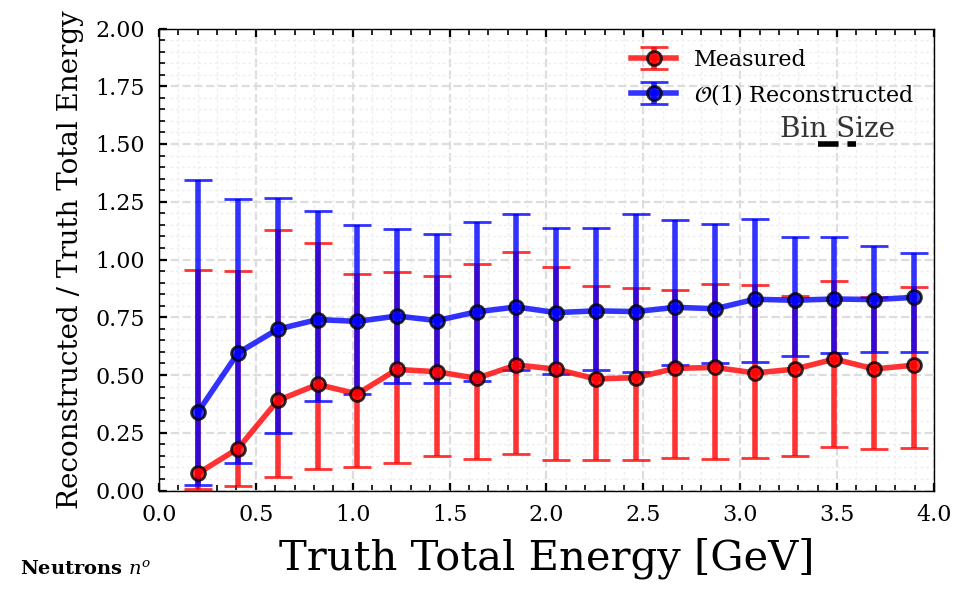

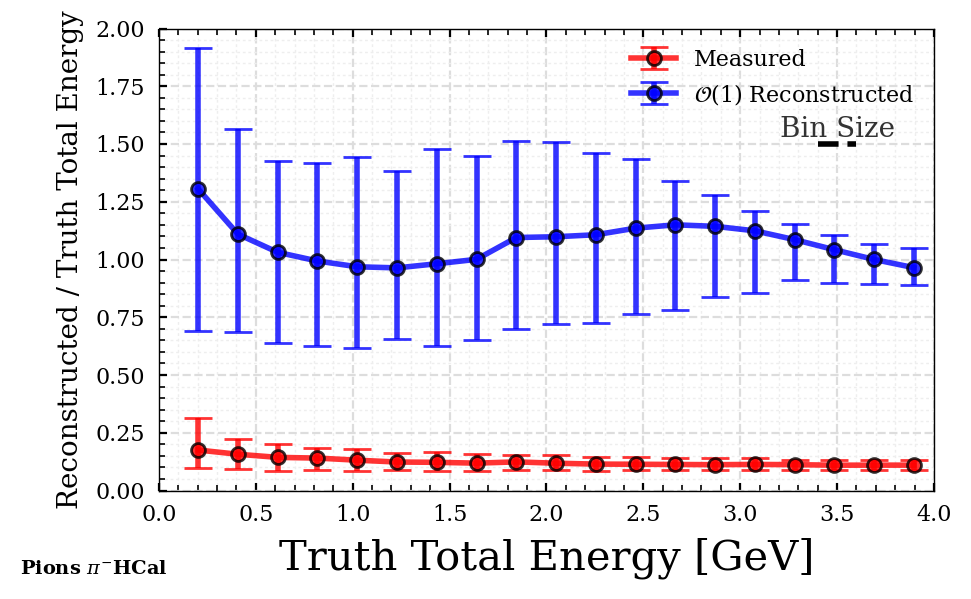

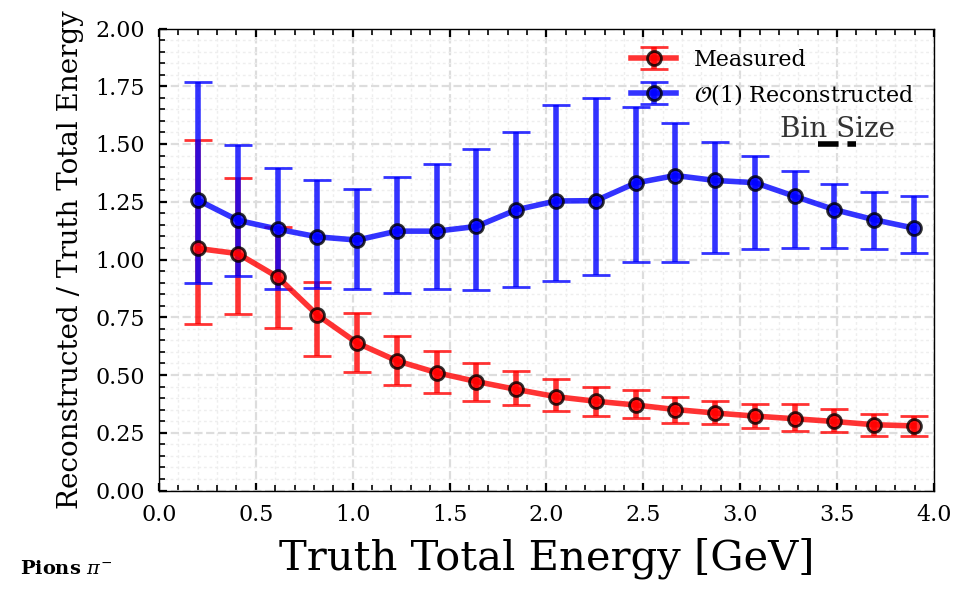

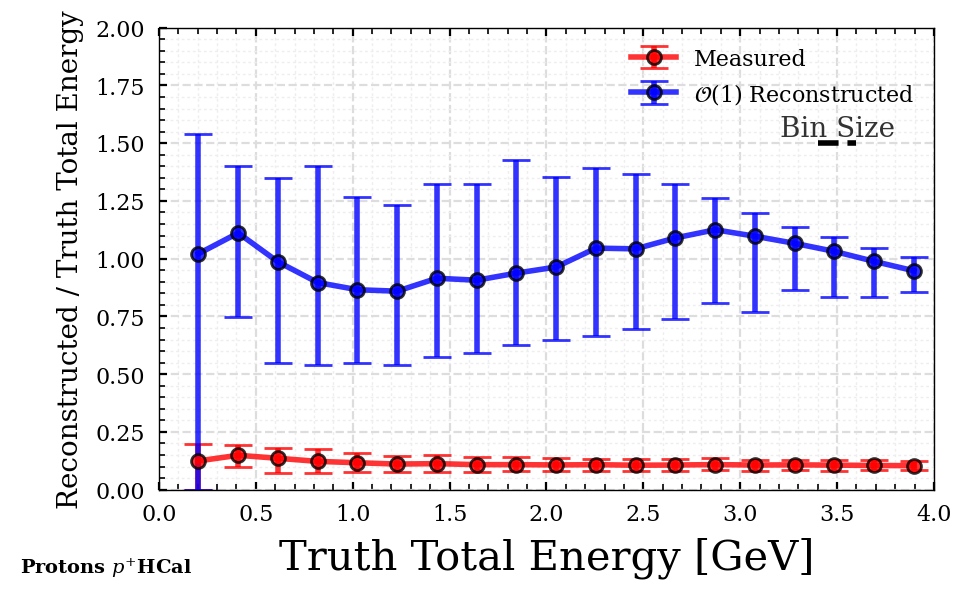

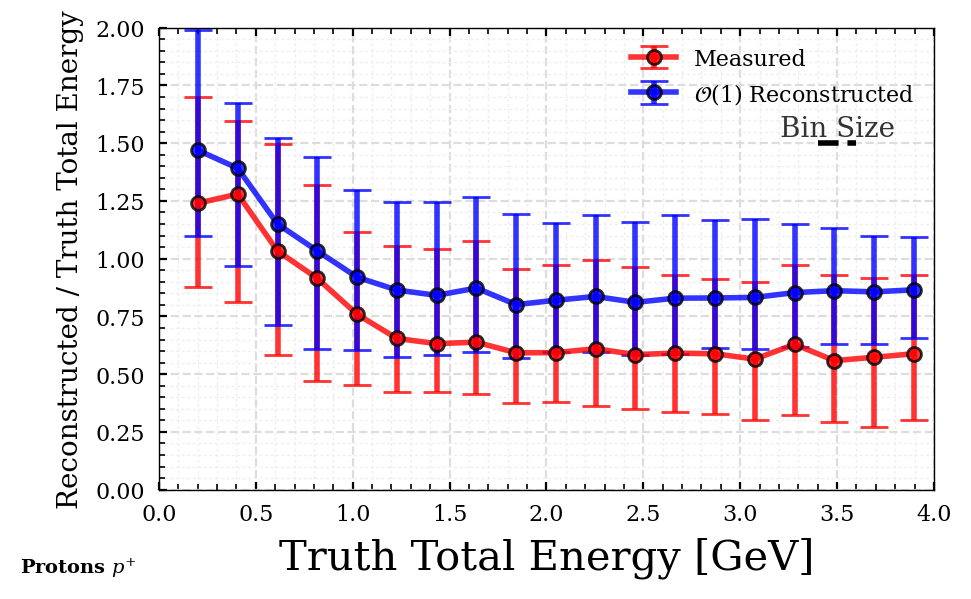

In [64]:
neutrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                            energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                            scheme=scheme, label=labels_dict['neutron']+'HCal')
neutrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                       energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                       scheme=scheme, label=labels_dict['neutron'])
pions_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                         energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                         scheme=scheme, label=labels_dict['pion']+'HCal')
pions.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                    energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                    scheme=scheme, label=labels_dict['pion'])
protons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                           scheme=scheme, label=labels_dict['proton']+'HCal')
protons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
                      scheme=scheme, label=labels_dict['proton'])

#### Per-Particle

In [65]:
# neutrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                             energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
#                             scheme=scheme, label=labels_dict['neutron']+'HCal')
# neutrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                        energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[2],
#                        scheme=scheme, label=labels_dict['neutron'])
# pions_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                          energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
#                          scheme=scheme, label=labels_dict['pion']+'HCal')
# pions.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                     energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[3],
#                     scheme=scheme, label=labels_dict['pion'])
# protons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                            energy_bins_hcal=ext_bins_hcal, o1corr_hcal=pe_o1corr_hcal,
#                            scheme=scheme, label=labels_dict['proton']+'HCal')
# protons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
#                       energy_bins_hcal=ext_bins_hcal, o1corr_hcal=ext_o1corrs_hcal[4],
#                       scheme=scheme, label=labels_dict['proton'])

## Investigating other particles

In [66]:
_ = pions.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  9873                9867                -0.63         0.43            -0.04
PFCandidates_ecalClusterDYDZ  9873                9872                -0.48         0.56            0.00
PFCandidates_ecalClusterEDXDZ 9873                9867                0.00          0.08            0.00
PFCandidates_ecalClusterEDYDZ 9873                9873                0.00          0.04            0.00
PFCandidates_ecalClusterEX    9873                9859                0.24        120.05            22.95
PFCandidates_ecalClusterEY    9873                9840                0.00        104.30            22.26
PFCandidates_ecalClusterEZ    9873                4143                3.30        182.73            131.69
PFCandidates_ecalClusterX     9873                9687                -184.14     179.66            -15.63
PFCandidates_ecalClusterY     9873              

# Saving the Particles

In [67]:
# HCal particles
hcal_particles_dict = {
    'electrons_hcal': electrons_hcal,
    'photons_hcal': photons_hcal,
    'neutrons_hcal': neutrons_hcal,
    'pions_hcal': pions_hcal,
    'protons_hcal': protons_hcal
}


# ECal + HCal particles
both_particles_dict = {
    'electrons': electrons,
    'photons': photons,
    'neutrons': neutrons,
    'pions': pions,
    'protons': protons
}

In [68]:
import pickle

# dump the particles into pickle files
for file_name, particles in hcal_particles_dict.items():
    file = open(f"data/pickles/{file_name}.pkl", "wb")
    pickle.dump(particles, file)
    file.close()

for file_name, particles in both_particles_dict.items():
    file = open(f"data/pickles/{file_name}.pkl", "wb")
    pickle.dump(particles, file)
    file.close()